In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [37]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
y_train_ohe = pd.get_dummies(y_train)
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_train_ohe = tf.convert_to_tensor(y_train_ohe, dtype = 'float32')
y_test_ohe = pd.get_dummies(y_test)
y_test_ohe = tf.convert_to_tensor(y_test_ohe, dtype = 'float32')
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [208]:
class AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim):
        super(AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = reconstruction, labels = x))
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
#         true_output_z = tf.convert_to_tensor(make_moons(n_samples=len(x), noise = .1 )[0])
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [209]:
aae = AAE(2, 1000, 2, len(x_train[0]))

r_optimizer = tf.keras.optimizers.Nadam(learning_rate=.001)
d_optimizer = tf.keras.optimizers.Nadam(learning_rate=.001/5)
g_optimizer = tf.keras.optimizers.Nadam(learning_rate=.001)

In [210]:
latent_history = []
for i in tqdm(range(100)):
    if i == 29:
        r_optimizer.lr  = .0005
        d_optimizer.lr =.0005/5
        g_optimizer.lr =.0005
    elif i == 59:
        r_optimizer.lr = .0001
        d_optimizer.lr = .0001/5
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:16<27:23, 16.60s/it]

epoch : 0 train set : [ reconstruction_loss : 0.23852387070655823, discriminator_loss : 1.4063512086868286, generator_loss : 0.7103447318077087]
 test set : [ reconstruction_loss : 0.21390338242053986, discriminator_loss : 1.4257681369781494, generator_loss : 0.6829373240470886]


  2%|█▋                                                                                | 2/100 [00:31<25:48, 15.80s/it]

epoch : 1 train set : [ reconstruction_loss : 0.2063881754875183, discriminator_loss : 1.3861806392669678, generator_loss : 0.7130123972892761]
 test set : [ reconstruction_loss : 0.20734287798404694, discriminator_loss : 1.4170842170715332, generator_loss : 0.6909742951393127]


  3%|██▍                                                                               | 3/100 [00:46<24:49, 15.36s/it]

epoch : 2 train set : [ reconstruction_loss : 0.20374451577663422, discriminator_loss : 1.3871970176696777, generator_loss : 0.6975449919700623]
 test set : [ reconstruction_loss : 0.2067081332206726, discriminator_loss : 1.3867676258087158, generator_loss : 0.691825807094574]


  4%|███▎                                                                              | 4/100 [01:01<24:27, 15.28s/it]

epoch : 3 train set : [ reconstruction_loss : 0.20415490865707397, discriminator_loss : 1.3871186971664429, generator_loss : 0.6954115033149719]
 test set : [ reconstruction_loss : 0.20385004580020905, discriminator_loss : 1.3925392627716064, generator_loss : 0.6835892796516418]


  5%|████                                                                              | 5/100 [01:16<24:06, 15.23s/it]

epoch : 4 train set : [ reconstruction_loss : 0.20650678873062134, discriminator_loss : 1.3867708444595337, generator_loss : 0.6931954026222229]
 test set : [ reconstruction_loss : 0.23023979365825653, discriminator_loss : 1.4204349517822266, generator_loss : 0.6581200957298279]


  6%|████▉                                                                             | 6/100 [01:32<23:47, 15.18s/it]

epoch : 5 train set : [ reconstruction_loss : 0.20537494122982025, discriminator_loss : 1.3876107931137085, generator_loss : 0.6942031979560852]
 test set : [ reconstruction_loss : 0.21427732706069946, discriminator_loss : 1.38267183303833, generator_loss : 0.6801670789718628]


  7%|█████▋                                                                            | 7/100 [01:47<23:30, 15.17s/it]

epoch : 6 train set : [ reconstruction_loss : 0.20350618660449982, discriminator_loss : 1.386948823928833, generator_loss : 0.6931763887405396]
 test set : [ reconstruction_loss : 0.21003226935863495, discriminator_loss : 1.3965203762054443, generator_loss : 0.6879842877388]


  8%|██████▌                                                                           | 8/100 [02:02<23:14, 15.16s/it]

epoch : 7 train set : [ reconstruction_loss : 0.20428995788097382, discriminator_loss : 1.3881014585494995, generator_loss : 0.6946427822113037]
 test set : [ reconstruction_loss : 0.20409151911735535, discriminator_loss : 1.3967244625091553, generator_loss : 0.6771356463432312]


  9%|███████▍                                                                          | 9/100 [02:17<22:59, 15.16s/it]

epoch : 8 train set : [ reconstruction_loss : 0.1971251219511032, discriminator_loss : 1.3868387937545776, generator_loss : 0.6929334998130798]
 test set : [ reconstruction_loss : 0.19811378419399261, discriminator_loss : 1.3974814414978027, generator_loss : 0.6837586760520935]


 10%|████████                                                                         | 10/100 [02:32<22:32, 15.03s/it]

epoch : 9 train set : [ reconstruction_loss : 0.1937723457813263, discriminator_loss : 1.3865412473678589, generator_loss : 0.6928889751434326]
 test set : [ reconstruction_loss : 0.1995357722043991, discriminator_loss : 1.3917310237884521, generator_loss : 0.688432514667511]


 11%|████████▉                                                                        | 11/100 [02:47<22:20, 15.06s/it]

epoch : 10 train set : [ reconstruction_loss : 0.19966039061546326, discriminator_loss : 1.3874635696411133, generator_loss : 0.6937974095344543]
 test set : [ reconstruction_loss : 0.20712138712406158, discriminator_loss : 1.384351134300232, generator_loss : 0.6888931393623352]


 12%|█████████▋                                                                       | 12/100 [03:02<22:07, 15.09s/it]

epoch : 11 train set : [ reconstruction_loss : 0.20133715867996216, discriminator_loss : 1.3869036436080933, generator_loss : 0.6934947967529297]
 test set : [ reconstruction_loss : 0.23359397053718567, discriminator_loss : 1.405702829360962, generator_loss : 0.6783213019371033]


 13%|██████████▌                                                                      | 13/100 [03:17<21:57, 15.14s/it]

epoch : 12 train set : [ reconstruction_loss : 0.20013776421546936, discriminator_loss : 1.387047290802002, generator_loss : 0.6935315728187561]
 test set : [ reconstruction_loss : 0.19973595440387726, discriminator_loss : 1.3884323835372925, generator_loss : 0.690970778465271]


 14%|███████████▎                                                                     | 14/100 [03:32<21:43, 15.16s/it]

epoch : 13 train set : [ reconstruction_loss : 0.20044876635074615, discriminator_loss : 1.3867512941360474, generator_loss : 0.6933020949363708]
 test set : [ reconstruction_loss : 0.20012442767620087, discriminator_loss : 1.3928203582763672, generator_loss : 0.6888527274131775]


 15%|████████████▏                                                                    | 15/100 [03:48<21:29, 15.17s/it]

epoch : 14 train set : [ reconstruction_loss : 0.206279456615448, discriminator_loss : 1.3871649503707886, generator_loss : 0.6939890384674072]
 test set : [ reconstruction_loss : 0.2072049379348755, discriminator_loss : 1.3877723217010498, generator_loss : 0.6905719637870789]


 16%|████████████▉                                                                    | 16/100 [04:03<21:17, 15.20s/it]

epoch : 15 train set : [ reconstruction_loss : 0.2022731453180313, discriminator_loss : 1.3866734504699707, generator_loss : 0.693343460559845]
 test set : [ reconstruction_loss : 0.211335226893425, discriminator_loss : 1.3849728107452393, generator_loss : 0.6928800940513611]


 17%|█████████████▊                                                                   | 17/100 [04:18<20:56, 15.14s/it]

epoch : 16 train set : [ reconstruction_loss : 0.20031043887138367, discriminator_loss : 1.3869167566299438, generator_loss : 0.6933557391166687]
 test set : [ reconstruction_loss : 0.20516148209571838, discriminator_loss : 1.3971540927886963, generator_loss : 0.686753511428833]


 18%|██████████████▌                                                                  | 18/100 [04:33<20:42, 15.15s/it]

epoch : 17 train set : [ reconstruction_loss : 0.19951528310775757, discriminator_loss : 1.3868263959884644, generator_loss : 0.6923916339874268]
 test set : [ reconstruction_loss : 0.2005372792482376, discriminator_loss : 1.3811795711517334, generator_loss : 0.7001672387123108]


 19%|███████████████▍                                                                 | 19/100 [04:48<20:29, 15.18s/it]

epoch : 18 train set : [ reconstruction_loss : 0.20114301145076752, discriminator_loss : 1.3873448371887207, generator_loss : 0.6936522722244263]
 test set : [ reconstruction_loss : 0.20873989164829254, discriminator_loss : 1.3889144659042358, generator_loss : 0.6872840523719788]


 20%|████████████████▏                                                                | 20/100 [05:04<20:14, 15.18s/it]

epoch : 19 train set : [ reconstruction_loss : 0.19642607867717743, discriminator_loss : 1.386961817741394, generator_loss : 0.6933068633079529]
 test set : [ reconstruction_loss : 0.1984362155199051, discriminator_loss : 1.3914902210235596, generator_loss : 0.6936190724372864]


 21%|█████████████████                                                                | 21/100 [05:19<19:59, 15.19s/it]

epoch : 20 train set : [ reconstruction_loss : 0.19871164858341217, discriminator_loss : 1.3866691589355469, generator_loss : 0.6930662989616394]
 test set : [ reconstruction_loss : 0.19634996354579926, discriminator_loss : 1.3819823265075684, generator_loss : 0.6934143304824829]


 22%|█████████████████▊                                                               | 22/100 [05:34<19:45, 15.19s/it]

epoch : 21 train set : [ reconstruction_loss : 0.20626096427440643, discriminator_loss : 1.3875130414962769, generator_loss : 0.6934228539466858]
 test set : [ reconstruction_loss : 0.20127767324447632, discriminator_loss : 1.3856446743011475, generator_loss : 0.6957476735115051]


 23%|██████████████████▋                                                              | 23/100 [05:49<19:30, 15.20s/it]

epoch : 22 train set : [ reconstruction_loss : 0.1944955438375473, discriminator_loss : 1.386450171470642, generator_loss : 0.6931876540184021]
 test set : [ reconstruction_loss : 0.19817446172237396, discriminator_loss : 1.3869249820709229, generator_loss : 0.6908014416694641]


 24%|███████████████████▍                                                             | 24/100 [06:04<19:05, 15.07s/it]

epoch : 23 train set : [ reconstruction_loss : 0.20041964948177338, discriminator_loss : 1.3866649866104126, generator_loss : 0.6930505633354187]
 test set : [ reconstruction_loss : 0.19900089502334595, discriminator_loss : 1.3852405548095703, generator_loss : 0.6923528909683228]


 25%|████████████████████▎                                                            | 25/100 [06:19<18:53, 15.12s/it]

epoch : 24 train set : [ reconstruction_loss : 0.20217005908489227, discriminator_loss : 1.3865569829940796, generator_loss : 0.6931167840957642]
 test set : [ reconstruction_loss : 0.20011991262435913, discriminator_loss : 1.3841629028320312, generator_loss : 0.6943902373313904]


 26%|█████████████████████                                                            | 26/100 [06:34<18:40, 15.14s/it]

epoch : 25 train set : [ reconstruction_loss : 0.20243579149246216, discriminator_loss : 1.3865331411361694, generator_loss : 0.6929641366004944]
 test set : [ reconstruction_loss : 0.19985036551952362, discriminator_loss : 1.389085292816162, generator_loss : 0.6927274465560913]


 27%|█████████████████████▊                                                           | 27/100 [06:50<18:26, 15.16s/it]

epoch : 26 train set : [ reconstruction_loss : 0.2016884833574295, discriminator_loss : 1.3864926099777222, generator_loss : 0.693206787109375]
 test set : [ reconstruction_loss : 0.20504635572433472, discriminator_loss : 1.3862354755401611, generator_loss : 0.6926851272583008]


 28%|██████████████████████▋                                                          | 28/100 [07:05<18:13, 15.18s/it]

epoch : 27 train set : [ reconstruction_loss : 0.21256643533706665, discriminator_loss : 1.386906385421753, generator_loss : 0.6929605603218079]
 test set : [ reconstruction_loss : 0.20631422102451324, discriminator_loss : 1.3879976272583008, generator_loss : 0.6927023530006409]


 29%|███████████████████████▍                                                         | 29/100 [07:20<17:58, 15.20s/it]

epoch : 28 train set : [ reconstruction_loss : 0.20367375016212463, discriminator_loss : 1.3866477012634277, generator_loss : 0.693270742893219]
 test set : [ reconstruction_loss : 0.20311039686203003, discriminator_loss : 1.3887310028076172, generator_loss : 0.6928532719612122]


 30%|████████████████████████▎                                                        | 30/100 [07:35<17:43, 15.20s/it]

epoch : 29 train set : [ reconstruction_loss : 0.20674459636211395, discriminator_loss : 1.3869447708129883, generator_loss : 0.693226158618927]
 test set : [ reconstruction_loss : 0.22604919970035553, discriminator_loss : 1.3877029418945312, generator_loss : 0.6890390515327454]


 31%|█████████████████████████                                                        | 31/100 [07:50<17:19, 15.07s/it]

epoch : 30 train set : [ reconstruction_loss : 0.24991898238658905, discriminator_loss : 1.4018189907073975, generator_loss : 0.7008835673332214]
 test set : [ reconstruction_loss : 0.23797507584095, discriminator_loss : 1.4090166091918945, generator_loss : 0.7040090560913086]


 32%|█████████████████████████▉                                                       | 32/100 [08:05<17:07, 15.10s/it]

epoch : 31 train set : [ reconstruction_loss : 0.2213497906923294, discriminator_loss : 1.3888521194458008, generator_loss : 0.698427140712738]
 test set : [ reconstruction_loss : 0.21537679433822632, discriminator_loss : 1.392000436782837, generator_loss : 0.6941801905632019]


 33%|██████████████████████████▋                                                      | 33/100 [08:20<16:55, 15.15s/it]

epoch : 32 train set : [ reconstruction_loss : 0.2149410992860794, discriminator_loss : 1.3898918628692627, generator_loss : 0.6935699582099915]
 test set : [ reconstruction_loss : 0.22128364443778992, discriminator_loss : 1.3677456378936768, generator_loss : 0.7211905121803284]


 34%|███████████████████████████▌                                                     | 34/100 [08:36<16:41, 15.17s/it]

epoch : 33 train set : [ reconstruction_loss : 0.20963381230831146, discriminator_loss : 1.3890714645385742, generator_loss : 0.6940696239471436]
 test set : [ reconstruction_loss : 0.20423424243927002, discriminator_loss : 1.3890290260314941, generator_loss : 0.6913074851036072]


 35%|████████████████████████████▎                                                    | 35/100 [08:51<16:26, 15.18s/it]

epoch : 34 train set : [ reconstruction_loss : 0.20032061636447906, discriminator_loss : 1.3867114782333374, generator_loss : 0.6930423974990845]
 test set : [ reconstruction_loss : 0.19913743436336517, discriminator_loss : 1.3845129013061523, generator_loss : 0.6936989426612854]


 36%|█████████████████████████████▏                                                   | 36/100 [09:06<16:12, 15.19s/it]

epoch : 35 train set : [ reconstruction_loss : 0.19987960159778595, discriminator_loss : 1.3866902589797974, generator_loss : 0.6949471235275269]
 test set : [ reconstruction_loss : 0.20668980479240417, discriminator_loss : 1.398409366607666, generator_loss : 0.6997661590576172]


 37%|█████████████████████████████▉                                                   | 37/100 [09:21<15:57, 15.19s/it]

epoch : 36 train set : [ reconstruction_loss : 0.198622927069664, discriminator_loss : 1.3874609470367432, generator_loss : 0.6920750737190247]
 test set : [ reconstruction_loss : 0.19625718891620636, discriminator_loss : 1.3830426931381226, generator_loss : 0.693576455116272]


 38%|██████████████████████████████▊                                                  | 38/100 [09:36<15:34, 15.07s/it]

epoch : 37 train set : [ reconstruction_loss : 0.1981269121170044, discriminator_loss : 1.3874129056930542, generator_loss : 0.6942093968391418]
 test set : [ reconstruction_loss : 0.19694262742996216, discriminator_loss : 1.388371467590332, generator_loss : 0.6898589134216309]


 39%|███████████████████████████████▌                                                 | 39/100 [09:51<15:22, 15.12s/it]

epoch : 38 train set : [ reconstruction_loss : 0.1980035901069641, discriminator_loss : 1.3876103162765503, generator_loss : 0.692894697189331]
 test set : [ reconstruction_loss : 0.19834578037261963, discriminator_loss : 1.3851925134658813, generator_loss : 0.6904554963111877]


 40%|████████████████████████████████▍                                                | 40/100 [10:07<15:08, 15.15s/it]

epoch : 39 train set : [ reconstruction_loss : 0.1974726766347885, discriminator_loss : 1.3872432708740234, generator_loss : 0.6934056878089905]
 test set : [ reconstruction_loss : 0.1960437297821045, discriminator_loss : 1.3841264247894287, generator_loss : 0.6972023844718933]


 41%|█████████████████████████████████▏                                               | 41/100 [10:22<14:54, 15.16s/it]

epoch : 40 train set : [ reconstruction_loss : 0.19230112433433533, discriminator_loss : 1.386810541152954, generator_loss : 0.6930890679359436]
 test set : [ reconstruction_loss : 0.19235049188137054, discriminator_loss : 1.3876903057098389, generator_loss : 0.6916268467903137]


 42%|██████████████████████████████████                                               | 42/100 [10:37<14:39, 15.17s/it]

epoch : 41 train set : [ reconstruction_loss : 0.1903294175863266, discriminator_loss : 1.3864288330078125, generator_loss : 0.6933677196502686]
 test set : [ reconstruction_loss : 0.19687798619270325, discriminator_loss : 1.3850829601287842, generator_loss : 0.6919375658035278]


 43%|██████████████████████████████████▊                                              | 43/100 [10:52<14:25, 15.19s/it]

epoch : 42 train set : [ reconstruction_loss : 0.20124787092208862, discriminator_loss : 1.3873435258865356, generator_loss : 0.692803680896759]
 test set : [ reconstruction_loss : 0.19697003066539764, discriminator_loss : 1.3913233280181885, generator_loss : 0.6905999779701233]


 44%|███████████████████████████████████▋                                             | 44/100 [11:07<14:11, 15.20s/it]

epoch : 43 train set : [ reconstruction_loss : 0.20300669968128204, discriminator_loss : 1.3880224227905273, generator_loss : 0.6929271221160889]
 test set : [ reconstruction_loss : 0.19121626019477844, discriminator_loss : 1.3887760639190674, generator_loss : 0.6891356706619263]


 45%|████████████████████████████████████▍                                            | 45/100 [11:22<13:48, 15.07s/it]

epoch : 44 train set : [ reconstruction_loss : 0.18936721980571747, discriminator_loss : 1.3865889310836792, generator_loss : 0.6931383013725281]
 test set : [ reconstruction_loss : 0.1887834072113037, discriminator_loss : 1.3843426704406738, generator_loss : 0.692436933517456]


 46%|█████████████████████████████████████▎                                           | 46/100 [11:37<13:36, 15.12s/it]

epoch : 45 train set : [ reconstruction_loss : 0.189499631524086, discriminator_loss : 1.3867124319076538, generator_loss : 0.6929221749305725]
 test set : [ reconstruction_loss : 0.1909949630498886, discriminator_loss : 1.3859169483184814, generator_loss : 0.6936964988708496]


 47%|██████████████████████████████████████                                           | 47/100 [11:53<13:22, 15.14s/it]

epoch : 46 train set : [ reconstruction_loss : 0.20436692237854004, discriminator_loss : 1.387564778327942, generator_loss : 0.6930429935455322]
 test set : [ reconstruction_loss : 0.20789265632629395, discriminator_loss : 1.404017448425293, generator_loss : 0.6767074465751648]


 48%|██████████████████████████████████████▉                                          | 48/100 [12:08<13:08, 15.16s/it]

epoch : 47 train set : [ reconstruction_loss : 0.1934177130460739, discriminator_loss : 1.3868727684020996, generator_loss : 0.6934119462966919]
 test set : [ reconstruction_loss : 0.1975174844264984, discriminator_loss : 1.4013855457305908, generator_loss : 0.6844549179077148]


 49%|███████████████████████████████████████▋                                         | 49/100 [12:23<12:53, 15.17s/it]

epoch : 48 train set : [ reconstruction_loss : 0.1893240064382553, discriminator_loss : 1.3867146968841553, generator_loss : 0.6930431127548218]
 test set : [ reconstruction_loss : 0.1888124644756317, discriminator_loss : 1.3864665031433105, generator_loss : 0.6939922571182251]


 50%|████████████████████████████████████████▌                                        | 50/100 [12:38<12:39, 15.19s/it]

epoch : 49 train set : [ reconstruction_loss : 0.18589486181735992, discriminator_loss : 1.386366605758667, generator_loss : 0.6932888627052307]
 test set : [ reconstruction_loss : 0.18583209812641144, discriminator_loss : 1.385977029800415, generator_loss : 0.692855954170227]


 51%|█████████████████████████████████████████▎                                       | 51/100 [12:53<12:24, 15.19s/it]

epoch : 50 train set : [ reconstruction_loss : 0.18456469476222992, discriminator_loss : 1.386330008506775, generator_loss : 0.6931547522544861]
 test set : [ reconstruction_loss : 0.18572132289409637, discriminator_loss : 1.3854539394378662, generator_loss : 0.693241536617279]


 52%|██████████████████████████████████████████                                       | 52/100 [13:08<12:04, 15.10s/it]

epoch : 51 train set : [ reconstruction_loss : 0.18463943898677826, discriminator_loss : 1.3863308429718018, generator_loss : 0.6931512355804443]
 test set : [ reconstruction_loss : 0.18706564605236053, discriminator_loss : 1.3856371641159058, generator_loss : 0.6931820511817932]


 53%|██████████████████████████████████████████▉                                      | 53/100 [13:24<11:52, 15.15s/it]

epoch : 52 train set : [ reconstruction_loss : 0.18513381481170654, discriminator_loss : 1.3863532543182373, generator_loss : 0.6931132078170776]
 test set : [ reconstruction_loss : 0.18522770702838898, discriminator_loss : 1.3863493204116821, generator_loss : 0.6930676698684692]


 54%|███████████████████████████████████████████▋                                     | 54/100 [13:39<11:37, 15.17s/it]

epoch : 53 train set : [ reconstruction_loss : 0.18944640457630157, discriminator_loss : 1.3863989114761353, generator_loss : 0.6930193305015564]
 test set : [ reconstruction_loss : 0.19149436056613922, discriminator_loss : 1.389451026916504, generator_loss : 0.6908884048461914]


 55%|████████████████████████████████████████████▌                                    | 55/100 [13:54<11:22, 15.18s/it]

epoch : 54 train set : [ reconstruction_loss : 0.18602360785007477, discriminator_loss : 1.3864420652389526, generator_loss : 0.6932267546653748]
 test set : [ reconstruction_loss : 0.18568405508995056, discriminator_loss : 1.386549711227417, generator_loss : 0.6929250955581665]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [14:09<11:08, 15.18s/it]

epoch : 55 train set : [ reconstruction_loss : 0.18725110590457916, discriminator_loss : 1.386350154876709, generator_loss : 0.6931414008140564]
 test set : [ reconstruction_loss : 0.1940978616476059, discriminator_loss : 1.386681079864502, generator_loss : 0.6919719576835632]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [14:24<10:52, 15.18s/it]

epoch : 56 train set : [ reconstruction_loss : 0.18762436509132385, discriminator_loss : 1.3864164352416992, generator_loss : 0.6930814981460571]
 test set : [ reconstruction_loss : 0.18742826581001282, discriminator_loss : 1.3864253759384155, generator_loss : 0.6934059858322144]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [14:39<10:37, 15.17s/it]

epoch : 57 train set : [ reconstruction_loss : 0.1837289184331894, discriminator_loss : 1.3863104581832886, generator_loss : 0.6931453347206116]
 test set : [ reconstruction_loss : 0.18579594790935516, discriminator_loss : 1.3868985176086426, generator_loss : 0.6930416226387024]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [14:54<10:16, 15.05s/it]

epoch : 58 train set : [ reconstruction_loss : 0.18648475408554077, discriminator_loss : 1.3863481283187866, generator_loss : 0.6931468844413757]
 test set : [ reconstruction_loss : 0.18793770670890808, discriminator_loss : 1.3856830596923828, generator_loss : 0.6928785443305969]


 60%|████████████████████████████████████████████████▌                                | 60/100 [15:09<10:03, 15.10s/it]

epoch : 59 train set : [ reconstruction_loss : 0.18710015714168549, discriminator_loss : 1.386376142501831, generator_loss : 0.6931264996528625]
 test set : [ reconstruction_loss : 0.18588638305664062, discriminator_loss : 1.3866047859191895, generator_loss : 0.6931132078170776]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [15:25<09:49, 15.12s/it]

epoch : 60 train set : [ reconstruction_loss : 0.19013351202011108, discriminator_loss : 1.3864150047302246, generator_loss : 0.6931091547012329]
 test set : [ reconstruction_loss : 0.18813000619411469, discriminator_loss : 1.3859769105911255, generator_loss : 0.6932039260864258]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [15:40<09:35, 15.15s/it]

epoch : 61 train set : [ reconstruction_loss : 0.1849023699760437, discriminator_loss : 1.3863470554351807, generator_loss : 0.6931303143501282]
 test set : [ reconstruction_loss : 0.18454568088054657, discriminator_loss : 1.3863646984100342, generator_loss : 0.693110466003418]


 63%|███████████████████████████████████████████████████                              | 63/100 [15:55<09:21, 15.16s/it]

epoch : 62 train set : [ reconstruction_loss : 0.18443095684051514, discriminator_loss : 1.3863221406936646, generator_loss : 0.693145215511322]
 test set : [ reconstruction_loss : 0.1895386427640915, discriminator_loss : 1.3866451978683472, generator_loss : 0.6927375197410583]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [16:10<09:07, 15.20s/it]

epoch : 63 train set : [ reconstruction_loss : 0.20259594917297363, discriminator_loss : 1.3865102529525757, generator_loss : 0.6930888295173645]
 test set : [ reconstruction_loss : 0.1848379373550415, discriminator_loss : 1.3867065906524658, generator_loss : 0.69313645362854]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [16:25<08:51, 15.20s/it]

epoch : 64 train set : [ reconstruction_loss : 0.18493390083312988, discriminator_loss : 1.3863253593444824, generator_loss : 0.6931430101394653]
 test set : [ reconstruction_loss : 0.18815279006958008, discriminator_loss : 1.386122226715088, generator_loss : 0.6927566528320312]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [16:40<08:32, 15.08s/it]

epoch : 65 train set : [ reconstruction_loss : 0.18356315791606903, discriminator_loss : 1.3863276243209839, generator_loss : 0.6931381225585938]
 test set : [ reconstruction_loss : 0.182897686958313, discriminator_loss : 1.3864729404449463, generator_loss : 0.6931390762329102]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [16:56<08:19, 15.13s/it]

epoch : 66 train set : [ reconstruction_loss : 0.1834658980369568, discriminator_loss : 1.386314034461975, generator_loss : 0.6931480169296265]
 test set : [ reconstruction_loss : 0.19524528086185455, discriminator_loss : 1.38641357421875, generator_loss : 0.6930915117263794]


 68%|███████████████████████████████████████████████████████                          | 68/100 [17:11<08:05, 15.16s/it]

epoch : 67 train set : [ reconstruction_loss : 0.19602033495903015, discriminator_loss : 1.3864109516143799, generator_loss : 0.693120002746582]
 test set : [ reconstruction_loss : 0.18917834758758545, discriminator_loss : 1.386242389678955, generator_loss : 0.6929195523262024]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [17:26<07:50, 15.17s/it]

epoch : 68 train set : [ reconstruction_loss : 0.1883721649646759, discriminator_loss : 1.3863580226898193, generator_loss : 0.6931251883506775]
 test set : [ reconstruction_loss : 0.19948941469192505, discriminator_loss : 1.3868882656097412, generator_loss : 0.6923850178718567]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [17:41<07:35, 15.18s/it]

epoch : 69 train set : [ reconstruction_loss : 0.18713434040546417, discriminator_loss : 1.3863623142242432, generator_loss : 0.6931341290473938]
 test set : [ reconstruction_loss : 0.1838451474905014, discriminator_loss : 1.3866677284240723, generator_loss : 0.693167507648468]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [17:56<07:20, 15.19s/it]

epoch : 70 train set : [ reconstruction_loss : 0.18191327154636383, discriminator_loss : 1.3863087892532349, generator_loss : 0.6931437849998474]
 test set : [ reconstruction_loss : 0.18233194947242737, discriminator_loss : 1.386513590812683, generator_loss : 0.6931490302085876]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [18:12<07:05, 15.20s/it]

epoch : 71 train set : [ reconstruction_loss : 0.18935981392860413, discriminator_loss : 1.386346459388733, generator_loss : 0.6931344866752625]
 test set : [ reconstruction_loss : 0.19647860527038574, discriminator_loss : 1.3865225315093994, generator_loss : 0.6926032304763794]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [18:26<06:46, 15.07s/it]

epoch : 72 train set : [ reconstruction_loss : 0.19860626757144928, discriminator_loss : 1.3863859176635742, generator_loss : 0.6931264400482178]
 test set : [ reconstruction_loss : 0.18433412909507751, discriminator_loss : 1.3866157531738281, generator_loss : 0.6931174993515015]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [18:42<06:32, 15.10s/it]

epoch : 73 train set : [ reconstruction_loss : 0.18198451399803162, discriminator_loss : 1.386305809020996, generator_loss : 0.6931445002555847]
 test set : [ reconstruction_loss : 0.18209630250930786, discriminator_loss : 1.3863661289215088, generator_loss : 0.6931539177894592]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [18:57<06:18, 15.14s/it]

epoch : 74 train set : [ reconstruction_loss : 0.18305590748786926, discriminator_loss : 1.386301875114441, generator_loss : 0.6931504607200623]
 test set : [ reconstruction_loss : 0.19276146590709686, discriminator_loss : 1.3865227699279785, generator_loss : 0.6929265260696411]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [19:12<06:06, 15.28s/it]

epoch : 75 train set : [ reconstruction_loss : 0.18749158084392548, discriminator_loss : 1.3863314390182495, generator_loss : 0.6931333541870117]
 test set : [ reconstruction_loss : 0.1830618530511856, discriminator_loss : 1.38649320602417, generator_loss : 0.6930978298187256]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [19:28<05:50, 15.25s/it]

epoch : 76 train set : [ reconstruction_loss : 0.18146054446697235, discriminator_loss : 1.3863028287887573, generator_loss : 0.6931455135345459]
 test set : [ reconstruction_loss : 0.18349279463291168, discriminator_loss : 1.386301040649414, generator_loss : 0.693122923374176]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [19:43<05:35, 15.24s/it]

epoch : 77 train set : [ reconstruction_loss : 0.23035748302936554, discriminator_loss : 1.3871577978134155, generator_loss : 0.6927038431167603]
 test set : [ reconstruction_loss : 0.2796761989593506, discriminator_loss : 1.3992984294891357, generator_loss : 0.6846440434455872]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [19:58<05:19, 15.21s/it]

epoch : 78 train set : [ reconstruction_loss : 0.2584957778453827, discriminator_loss : 1.3914426565170288, generator_loss : 0.6925628781318665]
 test set : [ reconstruction_loss : 0.24914371967315674, discriminator_loss : 1.3293728828430176, generator_loss : 0.7714505791664124]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [20:13<05:01, 15.10s/it]

epoch : 79 train set : [ reconstruction_loss : 0.24742035567760468, discriminator_loss : 1.4024012088775635, generator_loss : 0.7070743441581726]
 test set : [ reconstruction_loss : 0.24217219650745392, discriminator_loss : 1.3600656986236572, generator_loss : 0.7342938184738159]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [20:28<04:47, 15.12s/it]

epoch : 80 train set : [ reconstruction_loss : 0.23837684094905853, discriminator_loss : 1.3824344873428345, generator_loss : 0.7066016793251038]
 test set : [ reconstruction_loss : 0.24218934774398804, discriminator_loss : 1.4490139484405518, generator_loss : 0.6881718635559082]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [20:43<04:32, 15.16s/it]

epoch : 81 train set : [ reconstruction_loss : 0.22528748214244843, discriminator_loss : 1.3945847749710083, generator_loss : 0.7004381418228149]
 test set : [ reconstruction_loss : 0.21879664063453674, discriminator_loss : 1.3766905069351196, generator_loss : 0.7132226824760437]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [20:58<04:17, 15.16s/it]

epoch : 82 train set : [ reconstruction_loss : 0.22039955854415894, discriminator_loss : 1.3853541612625122, generator_loss : 0.6986215114593506]
 test set : [ reconstruction_loss : 0.23272861540317535, discriminator_loss : 1.3633744716644287, generator_loss : 0.7311983108520508]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [21:14<04:02, 15.17s/it]

epoch : 83 train set : [ reconstruction_loss : 0.213344544172287, discriminator_loss : 1.3887640237808228, generator_loss : 0.691350519657135]
 test set : [ reconstruction_loss : 0.21077822148799896, discriminator_loss : 1.4167990684509277, generator_loss : 0.6783051490783691]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [21:29<03:47, 15.18s/it]

epoch : 84 train set : [ reconstruction_loss : 0.2082694172859192, discriminator_loss : 1.3889782428741455, generator_loss : 0.6933413743972778]
 test set : [ reconstruction_loss : 0.20553405582904816, discriminator_loss : 1.381371259689331, generator_loss : 0.7034403085708618]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [21:44<03:32, 15.19s/it]

epoch : 85 train set : [ reconstruction_loss : 0.2040998786687851, discriminator_loss : 1.3866180181503296, generator_loss : 0.6944146156311035]
 test set : [ reconstruction_loss : 0.202898770570755, discriminator_loss : 1.379995584487915, generator_loss : 0.7008934617042542]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [21:59<03:16, 15.08s/it]

epoch : 86 train set : [ reconstruction_loss : 0.20063921809196472, discriminator_loss : 1.3864316940307617, generator_loss : 0.693290114402771]
 test set : [ reconstruction_loss : 0.19964586198329926, discriminator_loss : 1.3861289024353027, generator_loss : 0.6920849680900574]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [22:14<03:01, 15.11s/it]

epoch : 87 train set : [ reconstruction_loss : 0.19956189393997192, discriminator_loss : 1.3866121768951416, generator_loss : 0.693551242351532]
 test set : [ reconstruction_loss : 0.20076896250247955, discriminator_loss : 1.3719313144683838, generator_loss : 0.708341658115387]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [22:29<02:46, 15.15s/it]

epoch : 88 train set : [ reconstruction_loss : 0.19819426536560059, discriminator_loss : 1.3870490789413452, generator_loss : 0.69243985414505]
 test set : [ reconstruction_loss : 0.19922783970832825, discriminator_loss : 1.3951483964920044, generator_loss : 0.6826289296150208]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [22:44<02:31, 15.16s/it]

epoch : 89 train set : [ reconstruction_loss : 0.19573545455932617, discriminator_loss : 1.387070894241333, generator_loss : 0.6924884915351868]
 test set : [ reconstruction_loss : 0.19489425420761108, discriminator_loss : 1.3892866373062134, generator_loss : 0.6927117109298706]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [23:00<02:16, 15.19s/it]

epoch : 90 train set : [ reconstruction_loss : 0.19449497759342194, discriminator_loss : 1.3862756490707397, generator_loss : 0.693109929561615]
 test set : [ reconstruction_loss : 0.19425423443317413, discriminator_loss : 1.38899827003479, generator_loss : 0.6914573311805725]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [23:15<02:01, 15.21s/it]

epoch : 91 train set : [ reconstruction_loss : 0.19390840828418732, discriminator_loss : 1.3861926794052124, generator_loss : 0.6925459504127502]
 test set : [ reconstruction_loss : 0.19379527866840363, discriminator_loss : 1.3903708457946777, generator_loss : 0.6913043856620789]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [23:30<01:46, 15.18s/it]

epoch : 92 train set : [ reconstruction_loss : 0.19355475902557373, discriminator_loss : 1.3862477540969849, generator_loss : 0.6930431723594666]
 test set : [ reconstruction_loss : 0.19364121556282043, discriminator_loss : 1.3899216651916504, generator_loss : 0.6915042400360107]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [23:45<01:30, 15.07s/it]

epoch : 93 train set : [ reconstruction_loss : 0.1932663768529892, discriminator_loss : 1.386215329170227, generator_loss : 0.6931787729263306]
 test set : [ reconstruction_loss : 0.1934092938899994, discriminator_loss : 1.389247179031372, generator_loss : 0.6916159987449646]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [24:00<01:15, 15.09s/it]

epoch : 94 train set : [ reconstruction_loss : 0.19313980638980865, discriminator_loss : 1.3862135410308838, generator_loss : 0.6933205127716064]
 test set : [ reconstruction_loss : 0.1935674250125885, discriminator_loss : 1.388766884803772, generator_loss : 0.6916843056678772]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [24:15<01:00, 15.12s/it]

epoch : 95 train set : [ reconstruction_loss : 0.19299961626529694, discriminator_loss : 1.3861937522888184, generator_loss : 0.6933044195175171]
 test set : [ reconstruction_loss : 0.19349005818367004, discriminator_loss : 1.3880014419555664, generator_loss : 0.6930670142173767]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [24:30<00:45, 15.15s/it]

epoch : 96 train set : [ reconstruction_loss : 0.19318147003650665, discriminator_loss : 1.3863016366958618, generator_loss : 0.6934947967529297]
 test set : [ reconstruction_loss : 0.19335560500621796, discriminator_loss : 1.3848226070404053, generator_loss : 0.6954202055931091]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [24:46<00:30, 15.15s/it]

epoch : 97 train set : [ reconstruction_loss : 0.19271525740623474, discriminator_loss : 1.386289119720459, generator_loss : 0.6931480765342712]
 test set : [ reconstruction_loss : 0.19296717643737793, discriminator_loss : 1.3858182430267334, generator_loss : 0.6946983337402344]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [25:01<00:15, 15.16s/it]

epoch : 98 train set : [ reconstruction_loss : 0.1929454356431961, discriminator_loss : 1.386387586593628, generator_loss : 0.6932662725448608]
 test set : [ reconstruction_loss : 0.1932051032781601, discriminator_loss : 1.3878058195114136, generator_loss : 0.6932645440101624]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [25:16<00:00, 15.16s/it]

epoch : 99 train set : [ reconstruction_loss : 0.1927439421415329, discriminator_loss : 1.386451244354248, generator_loss : 0.6933966279029846]
 test set : [ reconstruction_loss : 0.1923730969429016, discriminator_loss : 1.38670015335083, generator_loss : 0.6939297914505005]


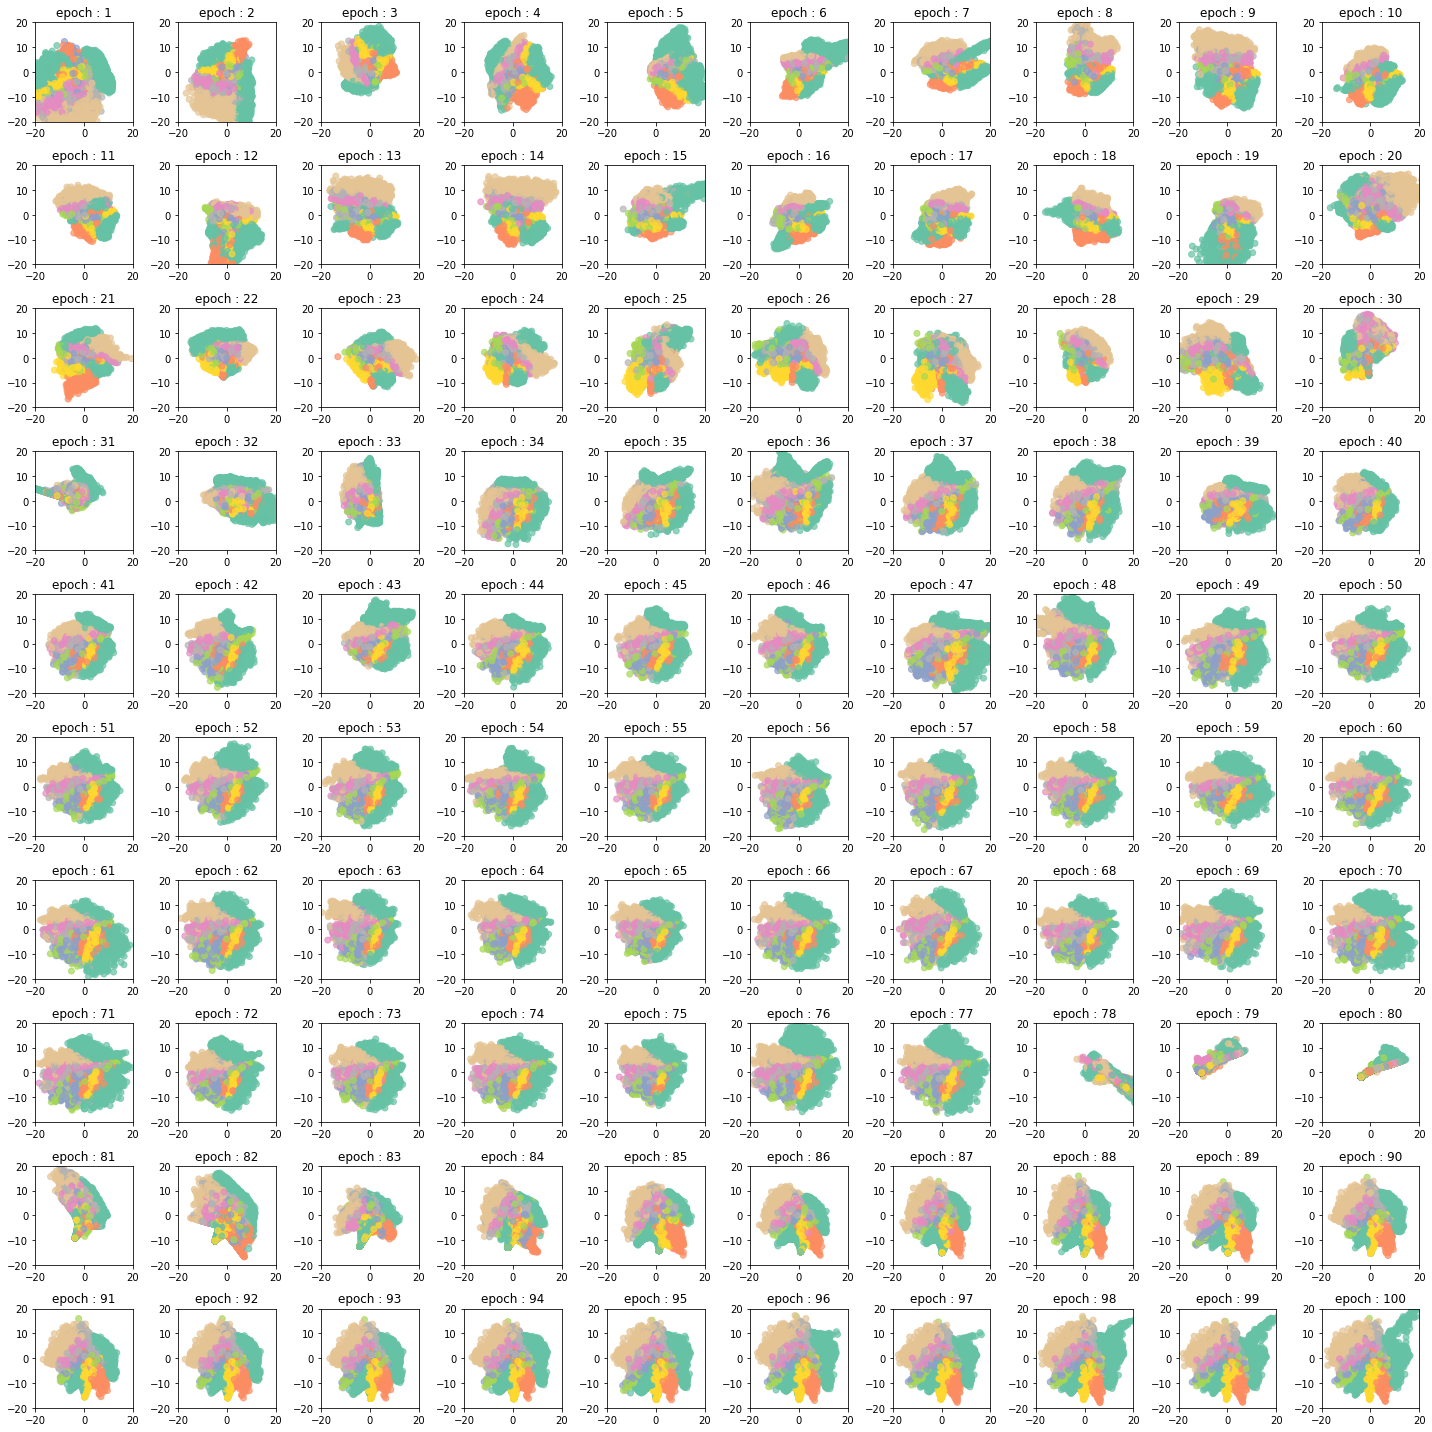

In [211]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i][:,0], latent_history[i][:,1], c = y_test, cmap = plt.cm.Set2, alpha = .7)
    ax[i//10, i%10].set_title(f'epoch : {i + 1}')
    ax[i//10, i%10].set_xlim(-20,20)
    ax[i//10, i%10].set_ylim(-20,20)
plt.tight_layout()

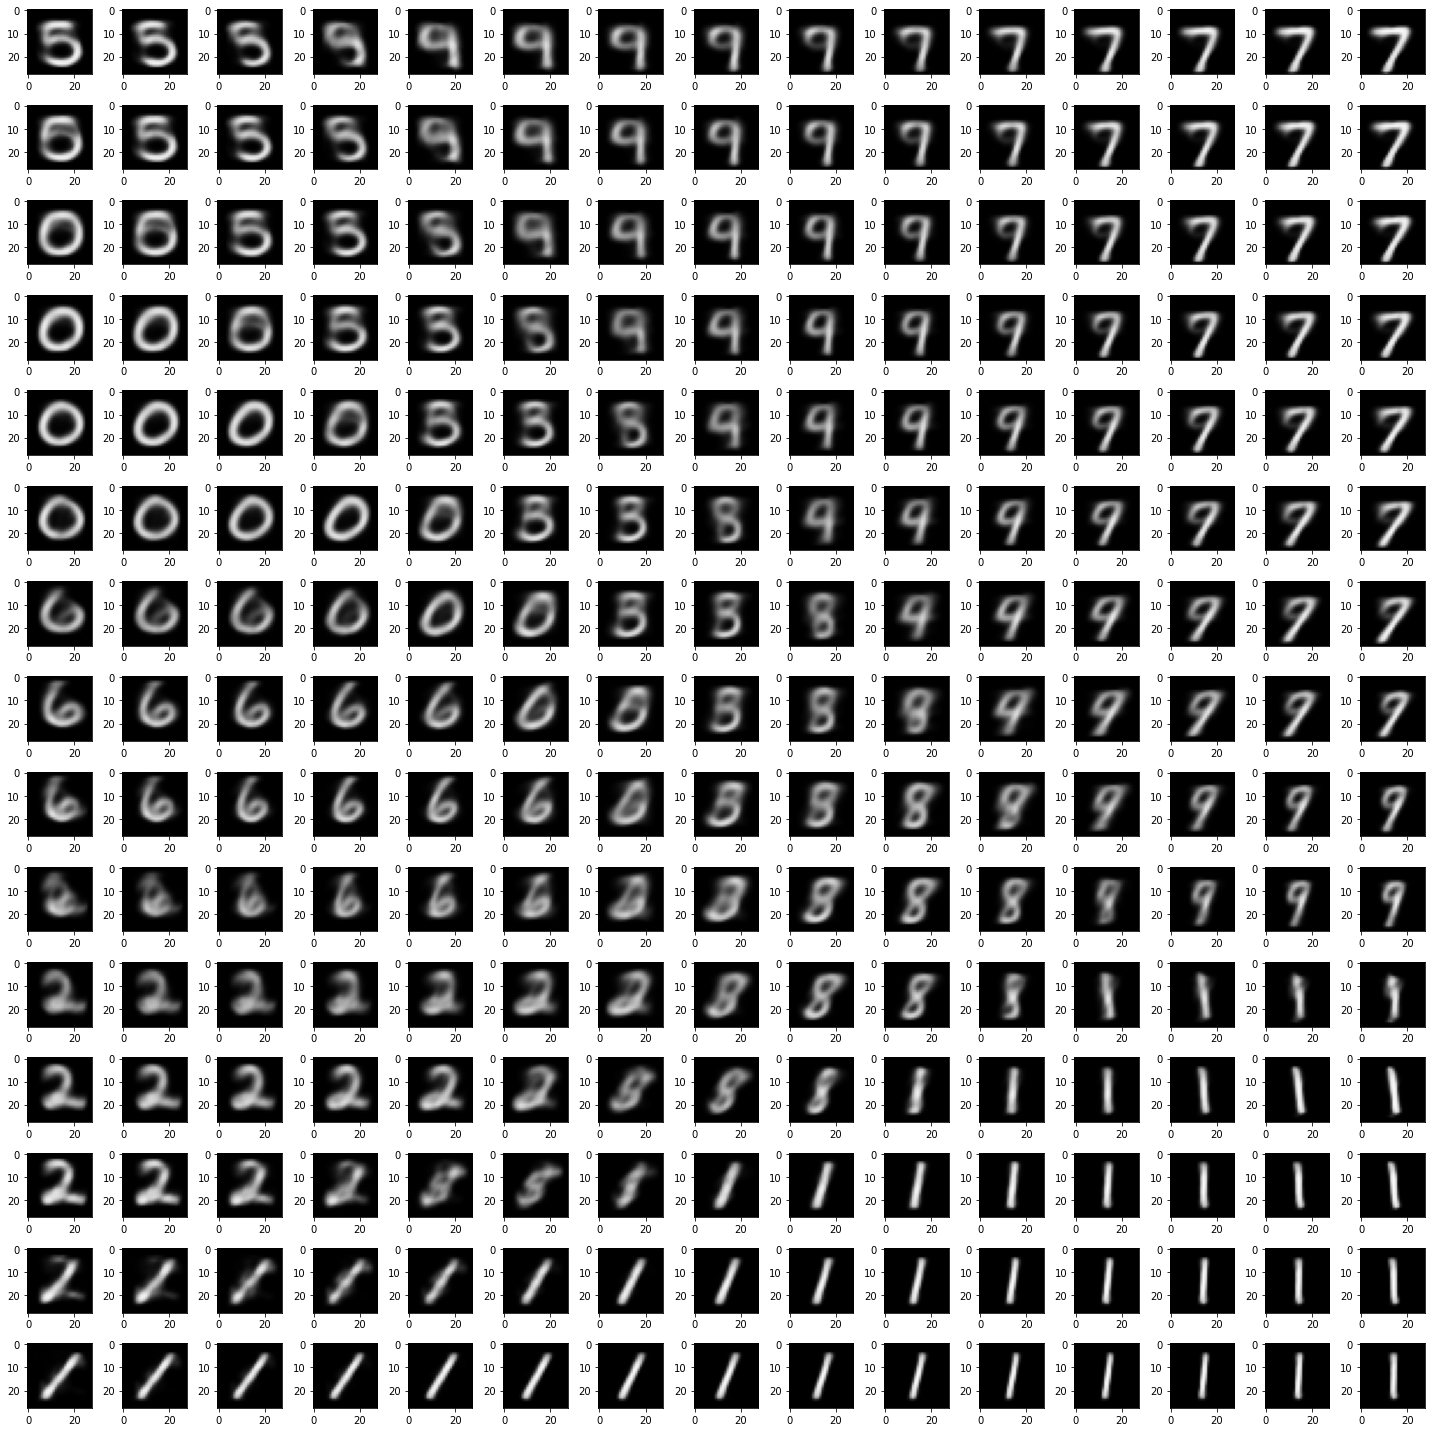

In [213]:
latent = tf.convert_to_tensor([[x,y] for x in np.linspace(-10, 10, 15) for y in np.linspace(10, -10, 15)], dtype = 'float32')
res = tf.math.sigmoid(aae.decode(latent))
res = tf.reshape(res, shape = (15*15, 28, 28)).numpy()

fig, ax = plt.subplots(15, 15, figsize = (20,20))
for i in range(15*15):
    ax[i//15, i%15].imshow(res[i], cmap='gray', vmin=0, vmax=1.)
plt.tight_layout()

In [2]:
class SSAAE(tf.keras.Model):
    def __init__(self, n_nodes, n_components, input_dim, n_categories, gaussian_noise:bool = True, stddev:float = .3, dropout:bool = False, dropout_rate:float = .2, batch_normalization:bool = False):
        super(SSAAE, self).__init__()
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        self.n_categories = n_categories
        self.gaussian_noise = gaussian_noise
        self.dropout = dropout
        self.stddev = stddev
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization
        self.acc = tf.keras.metrics.Accuracy()
        
        #encoder
        encoder_input = tf.keras.layers.Input(shape = [self.input_dim], name = 'encoder_input')
        if self.gaussian_noise:
            encoder_hidden = tf.keras.layers.GaussianNoise(stddev = self.stddev, name = 'gaussian_noise')(encoder_input)
        if self.dropout:
            encoder_hidden = tf.keras.layers.Dropout(rate = self.dropout_rate, name = 'dropout')(encoder_input)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'encoder_hidden_1')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'encoder_hidden_2')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        latent_z = tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'latent_z')(encoder_hidden)
        latent_y = tf.keras.layers.Dense(self.n_categories, activation = 'softmax', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'latent_y')(encoder_hidden)
        self.encoder = tf.keras.Model(inputs = [encoder_input], outputs = [latent_z, latent_y])
        
        #decoder
        decoder_input = tf.keras.layers.Input(shape = [self.n_components + self.n_categories], name = 'decoder_input')
        if self.batch_normalization:
            decoder_input = tf.keras.layers.BatchNormalization()(decoder_input)
        decoder_hidden = tf.keras.layers.Dense(self.n_components, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'decoder_hidden_1')(decoder_input)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        decoder_hidden = tf.keras.layers.Dense(self.n_components, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'decoder_hidden_2')(decoder_hidden)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        reconstruction = tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 42), name = 'reconstruction')(decoder_hidden)
        self.decoder = tf.keras.Model(inputs = [decoder_input], outputs = [reconstruction])
        
        #discriminator_z
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components], name = 'discriminator_z_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])
        
        #discriminator_y
        self.discriminator_y = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_categories], name = 'discriminator_y_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_y_output')
            ])
    
    #define feedforward propagation functions
    @tf.function
    def encode(self, x, training = False):
        latent_z, latent_y = self.encoder(x, training = training)
        return latent_z, latent_y
    
    @tf.function
    def decode(self, z, y):
        inputs = tf.concat([z, y], axis = 1)
        reconstruction = self.decoder(inputs)
        return reconstruction

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output
    
    @tf.function
    def discriminate_y(self, y):
        output = self.discriminator_y(y)
        return output

#define loss computing functions
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

def compute_classification_loss(x, y):
    classification_loss = tf.reduce_mean(K.categorical_crossentropy(target = x, output = y))
    return classification_loss

    
#define train function
@tf.function
def train_step(model, x, x_labled, x_unlabled, y, y_unlabled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x_unlabled, True)
        reconstruction = model.decode(latent_z, latent_y)
        reconstruction_loss = compute_reconstruction_loss(x_unlabled, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial
    model.discriminator_z.trainable = True
    model.discriminator_y.trainable = True
    model.encoder.trainable = False
    latent_z, latent_y = model.encode(x, True)
    #z
    with tf.GradientTape() as tape:
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))
    #y
    with tf.GradientTape() as tape:
        fake_y_logit = model.discriminate_y(latent_y)
        true_y_logit = model.discriminate_y(true_output_y)
        discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    d_gradients = tape.gradient(discriminator_y_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator
    model.discriminator_z.trainable = False
    model.discriminator_y.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x, True)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
        fake_y_output = model.discriminate_y(latent_y)
        generator_y_loss = compute_generator_loss(fake_y_output)
    g_gradients = tape.gradient([generator_z_loss, generator_y_loss], model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    #ss_classification
    with tf.GradientTape() as tape:
        _, latent_y = model.encode(x_labled, True)
        classification_loss = compute_classification_loss(y_labled, latent_y)
    ss_gradients = tape.gradient(classification_loss, model.trainable_variables)
    ss_optimizer.apply_gradients(zip(ss_gradients, model.trainable_variables))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss         

#define test function
@tf.function
def test_step(model, x, y, true_output_y):
    latent_z, latent_y = model.encode(x)
    reconstruction = model.decode(latent_z, latent_y)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    fake_y_logit = model.discriminate_y(latent_y)
    true_y_logit = model.discriminate_y(true_output_y)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    generator_y_loss = compute_generator_loss(fake_y_logit)
    classification_loss = compute_classification_loss(y, latent_y)
    accuracy = model.acc(tf.argmax(y, axis = 1), tf.argmax(latent_y, axis = 1))
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss, accuracy

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
color = y_test
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
idx, counts = np.unique(y_train[~np.isnan(y_train)], return_counts = True)
y_train = y_train.astype('float32')
for i in range(600):
    y_train[i * 100:(i*100)+97] = np.nan
y_train = tf.convert_to_tensor(y_train, dtype = 'float32')
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_test = tf.convert_to_tensor(pd.get_dummies(y_test), dtype = 'float32')

#def __init__(self, n_nodes, n_components, input_dim, n_categories):
ssaae = SSAAE(1000, 2, x_train.shape[1], 10, gaussian_noise= True)

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
ss_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [4]:
latent_y_history = []
latent_z_history = []
for j in tqdm(range(100)):
    #preprocessing
    y_categories = 10
    y_prob = counts / counts.sum()
    
    if i == 50:
        r_optimizer.lr  = .0001
        ss_optimizer.lr = .001
        d_optimizer.lr =.001
        g_optimizer.lr =.001
        
    reconstruction_loss = discriminator_z_loss = discriminator_y_loss = generator_z_loss = generator_y_loss = classification_loss = []
    for i in range(600):
        #preprocessing 
        x_batch_train = x_train[i * 100:(i+1)*100]
        y_batch_train = y_train[i * 100:(i+1)*100]
        mask = tf.math.is_nan(y_batch_train)
        x_unlabled = tf.boolean_mask(x_batch_train, mask)
        x_labled = tf.boolean_mask(x_batch_train, ~mask)
        y_labled = tf.boolean_mask(y_batch_train, ~mask)
        y_labled = tf.keras.utils.to_categorical(y_labled, num_classes = y_categories)
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = 10)
        
        #train
        r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labled, x_unlabled, y_batch_train, y_labled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
        reconstruction_loss.append(r)
        discriminator_z_loss.append(dz)
        discriminator_y_loss.append(dy)
        generator_z_loss.append(gz)
        generator_y_loss.append(gy)
        classification_loss.append(s)
    
    #test
    true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
    test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, x_test, y_test, true_output_y)
    reconstruction_loss = np.mean(reconstruction_loss)
    discriminator_z_loss = np.mean(discriminator_z_loss)
    discriminator_y_loss = np.mean(discriminator_y_loss)
    generator_z_loss = np.mean(generator_z_loss)
    generator_y_loss = np.mean(generator_y_loss)
    classification_loss = np.mean(classification_loss)
    
    z, y =ssaae.encode(x_test)
    latent_y_history.append(y)
    latent_z_history.append(z)
    print(f'epoch : {j + 1} train set : [ reconstruction_loss : {reconstruction_loss}, discriminator_z_loss : {discriminator_z_loss}, discriminator_y_loss : {discriminator_y_loss}, generator_z_loss : {generator_z_loss}, generator_y_loss : {generator_y_loss}, classification_loss : {classification_loss}]')
    print(f'epoch : {j + 1} test set : [ reconstruction_loss : {test_reconstruction}, discriminator_z_loss : {test_discriminator_z}, discriminator_y_loss : {test_discriminator_y}, generator_z_loss : {test_generator_z}, generator_y_loss : {test_generator_y}, classification_loss : {test_classification}, test_accuracy : {test_accuracy}]')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:11<18:21, 11.13s/it]

epoch : 1 train set : [ reconstruction_loss : 0.8881756663322449, discriminator_z_loss : 0.8881756663322449, discriminator_y_loss : 0.8881756663322449, generator_z_loss : 0.8881756663322449, generator_y_loss : 0.8881756663322449, classification_loss : 0.8881756663322449]
epoch : 1 test set : [ reconstruction_loss : 0.056637853384017944, discriminator_z_loss : 1.3725825548171997, discriminator_y_loss : 1.3789803981781006, generator_z_loss : 0.6988294720649719, generator_y_loss : 0.6966580152511597, classification_loss : 5.309020519256592, test_accuracy : 0.12250000238418579]


  2%|█▋                                                                                | 2/100 [00:19<15:47,  9.67s/it]

epoch : 2 train set : [ reconstruction_loss : 0.8687390089035034, discriminator_z_loss : 0.8687390089035034, discriminator_y_loss : 0.8687390089035034, generator_z_loss : 0.8687390089035034, generator_y_loss : 0.8687390089035034, classification_loss : 0.8687390089035034]
epoch : 2 test set : [ reconstruction_loss : 0.05629654973745346, discriminator_z_loss : 1.3370232582092285, discriminator_y_loss : 1.3455140590667725, generator_z_loss : 0.716224730014801, generator_y_loss : 0.7159789204597473, classification_loss : 5.348306179046631, test_accuracy : 0.11800000071525574]


  3%|██▍                                                                               | 3/100 [00:28<15:05,  9.33s/it]

epoch : 3 train set : [ reconstruction_loss : 0.8572179079055786, discriminator_z_loss : 0.8572179079055786, discriminator_y_loss : 0.8572179079055786, generator_z_loss : 0.8572179079055786, generator_y_loss : 0.8572179079055786, classification_loss : 0.8572179079055786]
epoch : 3 test set : [ reconstruction_loss : 0.055960383266210556, discriminator_z_loss : 1.3545268774032593, discriminator_y_loss : 0.9261504411697388, generator_z_loss : 0.7446065545082092, generator_y_loss : 1.1338757276535034, classification_loss : 5.174157619476318, test_accuracy : 0.11980000138282776]


  4%|███▎                                                                              | 4/100 [00:37<14:34,  9.11s/it]

epoch : 4 train set : [ reconstruction_loss : 0.875428318977356, discriminator_z_loss : 0.875428318977356, discriminator_y_loss : 0.875428318977356, generator_z_loss : 0.875428318977356, generator_y_loss : 0.875428318977356, classification_loss : 0.875428318977356]
epoch : 4 test set : [ reconstruction_loss : 0.05562926456332207, discriminator_z_loss : 1.3890511989593506, discriminator_y_loss : 0.451388418674469, generator_z_loss : 0.6790747046470642, generator_y_loss : 1.6961450576782227, classification_loss : 4.849997520446777, test_accuracy : 0.11357499659061432]


  5%|████                                                                              | 5/100 [00:46<14:09,  8.94s/it]

epoch : 5 train set : [ reconstruction_loss : 0.9141362905502319, discriminator_z_loss : 0.9141362905502319, discriminator_y_loss : 0.9141362905502319, generator_z_loss : 0.9141362905502319, generator_y_loss : 0.9141362905502319, classification_loss : 0.9141362905502319]
epoch : 5 test set : [ reconstruction_loss : 0.05530313402414322, discriminator_z_loss : 1.3456811904907227, discriminator_y_loss : 0.24943673610687256, generator_z_loss : 0.7054435014724731, generator_y_loss : 2.2444941997528076, classification_loss : 4.009172439575195, test_accuracy : 0.11305999755859375]


  6%|████▉                                                                             | 6/100 [00:54<13:51,  8.84s/it]

epoch : 6 train set : [ reconstruction_loss : 1.0178980827331543, discriminator_z_loss : 1.0178980827331543, discriminator_y_loss : 1.0178980827331543, generator_z_loss : 1.0178980827331543, generator_y_loss : 1.0178980827331543, classification_loss : 1.0178980827331543]
epoch : 6 test set : [ reconstruction_loss : 0.05498189479112625, discriminator_z_loss : 1.294740080833435, discriminator_y_loss : 0.11899629235267639, generator_z_loss : 0.7324392795562744, generator_y_loss : 3.78552508354187, classification_loss : 4.567744255065918, test_accuracy : 0.11041666567325592]


  7%|█████▋                                                                            | 7/100 [01:03<13:47,  8.89s/it]

epoch : 7 train set : [ reconstruction_loss : 1.1496020555496216, discriminator_z_loss : 1.1496020555496216, discriminator_y_loss : 1.1496020555496216, generator_z_loss : 1.1496020555496216, generator_y_loss : 1.1496020555496216, classification_loss : 1.1496020555496216]
epoch : 7 test set : [ reconstruction_loss : 0.054665494710206985, discriminator_z_loss : 1.1342494487762451, discriminator_y_loss : 0.10550466179847717, generator_z_loss : 0.8630340695381165, generator_y_loss : 4.2522501945495605, classification_loss : 4.9588093757629395, test_accuracy : 0.10684286057949066]


  8%|██████▌                                                                           | 8/100 [01:12<13:42,  8.94s/it]

epoch : 8 train set : [ reconstruction_loss : 1.2782487869262695, discriminator_z_loss : 1.2782487869262695, discriminator_y_loss : 1.2782487869262695, generator_z_loss : 1.2782487869262695, generator_y_loss : 1.2782487869262695, classification_loss : 1.2782487869262695]
epoch : 8 test set : [ reconstruction_loss : 0.05435384064912796, discriminator_z_loss : 1.3413300514221191, discriminator_y_loss : 0.06465523689985275, generator_z_loss : 0.8172080516815186, generator_y_loss : 5.153596878051758, classification_loss : 5.095295429229736, test_accuracy : 0.10580000281333923]


  9%|███████▍                                                                          | 9/100 [01:21<13:25,  8.85s/it]

epoch : 9 train set : [ reconstruction_loss : 1.3498843908309937, discriminator_z_loss : 1.3498843908309937, discriminator_y_loss : 1.3498843908309937, generator_z_loss : 1.3498843908309937, generator_y_loss : 1.3498843908309937, classification_loss : 1.3498843908309937]
epoch : 9 test set : [ reconstruction_loss : 0.054046884179115295, discriminator_z_loss : 1.32077956199646, discriminator_y_loss : 0.10599520802497864, generator_z_loss : 0.7180520296096802, generator_y_loss : 4.957749843597412, classification_loss : 5.217752456665039, test_accuracy : 0.10450000315904617]


 10%|████████                                                                         | 10/100 [01:30<13:14,  8.83s/it]

epoch : 10 train set : [ reconstruction_loss : 1.4433064460754395, discriminator_z_loss : 1.4433064460754395, discriminator_y_loss : 1.4433064460754395, generator_z_loss : 1.4433064460754395, generator_y_loss : 1.4433064460754395, classification_loss : 1.4433064460754395]
epoch : 10 test set : [ reconstruction_loss : 0.05374452471733093, discriminator_z_loss : 1.364534616470337, discriminator_y_loss : 0.1148565262556076, generator_z_loss : 0.7086981534957886, generator_y_loss : 5.706908702850342, classification_loss : 5.56299352645874, test_accuracy : 0.10318999737501144]


 11%|████████▉                                                                        | 11/100 [01:38<13:03,  8.80s/it]

epoch : 11 train set : [ reconstruction_loss : 1.492279052734375, discriminator_z_loss : 1.492279052734375, discriminator_y_loss : 1.492279052734375, generator_z_loss : 1.492279052734375, generator_y_loss : 1.492279052734375, classification_loss : 1.492279052734375]
epoch : 11 test set : [ reconstruction_loss : 0.053446706384420395, discriminator_z_loss : 1.3934332132339478, discriminator_y_loss : 0.21333205699920654, generator_z_loss : 0.7389904856681824, generator_y_loss : 5.283947944641113, classification_loss : 6.065335273742676, test_accuracy : 0.10422727465629578]


 12%|█████████▋                                                                       | 12/100 [01:48<13:23,  9.13s/it]

epoch : 12 train set : [ reconstruction_loss : 1.5393038988113403, discriminator_z_loss : 1.5393038988113403, discriminator_y_loss : 1.5393038988113403, generator_z_loss : 1.5393038988113403, generator_y_loss : 1.5393038988113403, classification_loss : 1.5393038988113403]
epoch : 12 test set : [ reconstruction_loss : 0.05315336585044861, discriminator_z_loss : 1.3869988918304443, discriminator_y_loss : 0.14926207065582275, generator_z_loss : 0.679344654083252, generator_y_loss : 5.806124687194824, classification_loss : 5.925469875335693, test_accuracy : 0.10559166967868805]


 13%|██████████▌                                                                      | 13/100 [01:57<13:04,  9.02s/it]

epoch : 13 train set : [ reconstruction_loss : 1.5871782302856445, discriminator_z_loss : 1.5871782302856445, discriminator_y_loss : 1.5871782302856445, generator_z_loss : 1.5871782302856445, generator_y_loss : 1.5871782302856445, classification_loss : 1.5871782302856445]
epoch : 13 test set : [ reconstruction_loss : 0.052864428609609604, discriminator_z_loss : 1.378795862197876, discriminator_y_loss : 0.12446334958076477, generator_z_loss : 0.7250264286994934, generator_y_loss : 6.759134292602539, classification_loss : 6.462949752807617, test_accuracy : 0.10414615273475647]


 14%|███████████▎                                                                     | 14/100 [02:06<12:48,  8.94s/it]

epoch : 14 train set : [ reconstruction_loss : 1.552446722984314, discriminator_z_loss : 1.552446722984314, discriminator_y_loss : 1.552446722984314, generator_z_loss : 1.552446722984314, generator_y_loss : 1.552446722984314, classification_loss : 1.552446722984314]
epoch : 14 test set : [ reconstruction_loss : 0.05257983133196831, discriminator_z_loss : 1.368443489074707, discriminator_y_loss : 0.2600368857383728, generator_z_loss : 0.7309234142303467, generator_y_loss : 6.145018577575684, classification_loss : 6.159578323364258, test_accuracy : 0.10576428472995758]


 15%|████████████▏                                                                    | 15/100 [02:15<12:34,  8.88s/it]

epoch : 15 train set : [ reconstruction_loss : 1.4646838903427124, discriminator_z_loss : 1.4646838903427124, discriminator_y_loss : 1.4646838903427124, generator_z_loss : 1.4646838903427124, generator_y_loss : 1.4646838903427124, classification_loss : 1.4646838903427124]
epoch : 15 test set : [ reconstruction_loss : 0.05229950696229935, discriminator_z_loss : 1.3799114227294922, discriminator_y_loss : 0.20713824033737183, generator_z_loss : 0.6944963932037354, generator_y_loss : 6.276547431945801, classification_loss : 5.865903854370117, test_accuracy : 0.10864000022411346]


 16%|████████████▉                                                                    | 16/100 [02:24<12:29,  8.93s/it]

epoch : 16 train set : [ reconstruction_loss : 1.5359491109848022, discriminator_z_loss : 1.5359491109848022, discriminator_y_loss : 1.5359491109848022, generator_z_loss : 1.5359491109848022, generator_y_loss : 1.5359491109848022, classification_loss : 1.5359491109848022]
epoch : 16 test set : [ reconstruction_loss : 0.05202338099479675, discriminator_z_loss : 1.3756259679794312, discriminator_y_loss : 0.19201165437698364, generator_z_loss : 0.708241879940033, generator_y_loss : 6.324391841888428, classification_loss : 6.441029071807861, test_accuracy : 0.11084999889135361]


 17%|█████████████▊                                                                   | 17/100 [02:33<12:20,  8.92s/it]

epoch : 17 train set : [ reconstruction_loss : 1.5163508653640747, discriminator_z_loss : 1.5163508653640747, discriminator_y_loss : 1.5163508653640747, generator_z_loss : 1.5163508653640747, generator_y_loss : 1.5163508653640747, classification_loss : 1.5163508653640747]
epoch : 17 test set : [ reconstruction_loss : 0.05175139755010605, discriminator_z_loss : 1.3689405918121338, discriminator_y_loss : 0.23438811302185059, generator_z_loss : 0.7136877179145813, generator_y_loss : 7.42083740234375, classification_loss : 6.560135841369629, test_accuracy : 0.11122941225767136]


 18%|██████████████▌                                                                  | 18/100 [02:41<12:08,  8.88s/it]

epoch : 18 train set : [ reconstruction_loss : 1.6074923276901245, discriminator_z_loss : 1.6074923276901245, discriminator_y_loss : 1.6074923276901245, generator_z_loss : 1.6074923276901245, generator_y_loss : 1.6074923276901245, classification_loss : 1.6074923276901245]
epoch : 18 test set : [ reconstruction_loss : 0.05148349329829216, discriminator_z_loss : 1.3218839168548584, discriminator_y_loss : 0.19637459516525269, generator_z_loss : 0.731254518032074, generator_y_loss : 6.264832496643066, classification_loss : 6.491389274597168, test_accuracy : 0.11264444142580032]


 19%|███████████████▍                                                                 | 19/100 [02:51<12:27,  9.22s/it]

epoch : 19 train set : [ reconstruction_loss : 1.6138715744018555, discriminator_z_loss : 1.6138715744018555, discriminator_y_loss : 1.6138715744018555, generator_z_loss : 1.6138715744018555, generator_y_loss : 1.6138715744018555, classification_loss : 1.6138715744018555]
epoch : 19 test set : [ reconstruction_loss : 0.05121961981058121, discriminator_z_loss : 1.2923355102539062, discriminator_y_loss : 0.22608619928359985, generator_z_loss : 0.755441427230835, generator_y_loss : 7.86320161819458, classification_loss : 6.571788311004639, test_accuracy : 0.11303684115409851]


 20%|████████████████▏                                                                | 20/100 [03:01<12:18,  9.23s/it]

epoch : 20 train set : [ reconstruction_loss : 1.6536152362823486, discriminator_z_loss : 1.6536152362823486, discriminator_y_loss : 1.6536152362823486, generator_z_loss : 1.6536152362823486, generator_y_loss : 1.6536152362823486, classification_loss : 1.6536152362823486]
epoch : 20 test set : [ reconstruction_loss : 0.05095968768000603, discriminator_z_loss : 1.2490812540054321, discriminator_y_loss : 0.14677661657333374, generator_z_loss : 0.7795518040657043, generator_y_loss : 7.736405372619629, classification_loss : 6.478321075439453, test_accuracy : 0.11321499943733215]


 21%|█████████████████                                                                | 21/100 [03:10<12:01,  9.13s/it]

epoch : 21 train set : [ reconstruction_loss : 1.649389386177063, discriminator_z_loss : 1.649389386177063, discriminator_y_loss : 1.649389386177063, generator_z_loss : 1.649389386177063, generator_y_loss : 1.649389386177063, classification_loss : 1.649389386177063]
epoch : 21 test set : [ reconstruction_loss : 0.05070364847779274, discriminator_z_loss : 1.2483582496643066, discriminator_y_loss : 0.09852713346481323, generator_z_loss : 0.7960370182991028, generator_y_loss : 7.3884992599487305, classification_loss : 6.361161708831787, test_accuracy : 0.11352857202291489]


 22%|█████████████████▊                                                               | 22/100 [03:18<11:41,  9.00s/it]

epoch : 22 train set : [ reconstruction_loss : 1.694333791732788, discriminator_z_loss : 1.694333791732788, discriminator_y_loss : 1.694333791732788, generator_z_loss : 1.694333791732788, generator_y_loss : 1.694333791732788, classification_loss : 1.694333791732788]
epoch : 22 test set : [ reconstruction_loss : 0.050451453775167465, discriminator_z_loss : 1.166139841079712, discriminator_y_loss : 0.1925254464149475, generator_z_loss : 0.8940131068229675, generator_y_loss : 6.9418625831604, classification_loss : 6.748434543609619, test_accuracy : 0.11367272585630417]


 23%|██████████████████▋                                                              | 23/100 [03:27<11:30,  8.96s/it]

epoch : 23 train set : [ reconstruction_loss : 1.7386255264282227, discriminator_z_loss : 1.7386255264282227, discriminator_y_loss : 1.7386255264282227, generator_z_loss : 1.7386255264282227, generator_y_loss : 1.7386255264282227, classification_loss : 1.7386255264282227]
epoch : 23 test set : [ reconstruction_loss : 0.05020303651690483, discriminator_z_loss : 1.3119525909423828, discriminator_y_loss : 0.23777228593826294, generator_z_loss : 0.7927700281143188, generator_y_loss : 7.722899913787842, classification_loss : 6.819952964782715, test_accuracy : 0.11446087062358856]


 24%|███████████████████▍                                                             | 24/100 [03:36<11:18,  8.93s/it]

epoch : 24 train set : [ reconstruction_loss : 1.7413218021392822, discriminator_z_loss : 1.7413218021392822, discriminator_y_loss : 1.7413218021392822, generator_z_loss : 1.7413218021392822, generator_y_loss : 1.7413218021392822, classification_loss : 1.7413218021392822]
epoch : 24 test set : [ reconstruction_loss : 0.049958329647779465, discriminator_z_loss : 1.286637783050537, discriminator_y_loss : 0.23708093166351318, generator_z_loss : 0.7563884854316711, generator_y_loss : 7.333581447601318, classification_loss : 7.092275142669678, test_accuracy : 0.11377916485071182]


 25%|████████████████████▎                                                            | 25/100 [03:45<11:13,  8.98s/it]

epoch : 25 train set : [ reconstruction_loss : 1.705141544342041, discriminator_z_loss : 1.705141544342041, discriminator_y_loss : 1.705141544342041, generator_z_loss : 1.705141544342041, generator_y_loss : 1.705141544342041, classification_loss : 1.705141544342041]
epoch : 25 test set : [ reconstruction_loss : 0.04971729964017868, discriminator_z_loss : 1.231003761291504, discriminator_y_loss : 0.2973026931285858, generator_z_loss : 0.81119704246521, generator_y_loss : 7.595802307128906, classification_loss : 7.048874378204346, test_accuracy : 0.1138639971613884]


 26%|█████████████████████                                                            | 26/100 [03:54<11:07,  9.02s/it]

epoch : 26 train set : [ reconstruction_loss : 1.797497272491455, discriminator_z_loss : 1.797497272491455, discriminator_y_loss : 1.797497272491455, generator_z_loss : 1.797497272491455, generator_y_loss : 1.797497272491455, classification_loss : 1.797497272491455]
epoch : 26 test set : [ reconstruction_loss : 0.04947987571358681, discriminator_z_loss : 1.3480011224746704, discriminator_y_loss : 0.24084395170211792, generator_z_loss : 0.7382233738899231, generator_y_loss : 6.818543910980225, classification_loss : 7.08975076675415, test_accuracy : 0.11370769143104553]


 27%|█████████████████████▊                                                           | 27/100 [04:03<11:00,  9.04s/it]

epoch : 27 train set : [ reconstruction_loss : 1.7503701448440552, discriminator_z_loss : 1.7503701448440552, discriminator_y_loss : 1.7503701448440552, generator_z_loss : 1.7503701448440552, generator_y_loss : 1.7503701448440552, classification_loss : 1.7503701448440552]
epoch : 27 test set : [ reconstruction_loss : 0.04924599826335907, discriminator_z_loss : 1.2731540203094482, discriminator_y_loss : 0.2823984622955322, generator_z_loss : 0.792580783367157, generator_y_loss : 7.7703423500061035, classification_loss : 7.126570224761963, test_accuracy : 0.1133074089884758]


 28%|██████████████████████▋                                                          | 28/100 [04:12<10:46,  8.98s/it]

epoch : 28 train set : [ reconstruction_loss : 1.8063666820526123, discriminator_z_loss : 1.8063666820526123, discriminator_y_loss : 1.8063666820526123, generator_z_loss : 1.8063666820526123, generator_y_loss : 1.8063666820526123, classification_loss : 1.8063666820526123]
epoch : 28 test set : [ reconstruction_loss : 0.04901562258601189, discriminator_z_loss : 1.2927091121673584, discriminator_y_loss : 0.24460327625274658, generator_z_loss : 0.801016092300415, generator_y_loss : 7.356636047363281, classification_loss : 7.048316955566406, test_accuracy : 0.11315356940031052]


 29%|███████████████████████▍                                                         | 29/100 [04:21<10:34,  8.93s/it]

epoch : 29 train set : [ reconstruction_loss : 1.788177728652954, discriminator_z_loss : 1.788177728652954, discriminator_y_loss : 1.788177728652954, generator_z_loss : 1.788177728652954, generator_y_loss : 1.788177728652954, classification_loss : 1.788177728652954]
epoch : 29 test set : [ reconstruction_loss : 0.04878868907690048, discriminator_z_loss : 1.2183663845062256, discriminator_y_loss : 0.36719226837158203, generator_z_loss : 0.9059336185455322, generator_y_loss : 5.6397929191589355, classification_loss : 7.330935955047607, test_accuracy : 0.11347930878400803]


 30%|████████████████████████▎                                                        | 30/100 [04:30<10:28,  8.97s/it]

epoch : 30 train set : [ reconstruction_loss : 1.8590517044067383, discriminator_z_loss : 1.8590517044067383, discriminator_y_loss : 1.8590517044067383, generator_z_loss : 1.8590517044067383, generator_y_loss : 1.8590517044067383, classification_loss : 1.8590517044067383]
epoch : 30 test set : [ reconstruction_loss : 0.04856514558196068, discriminator_z_loss : 1.260768175125122, discriminator_y_loss : 0.45370209217071533, generator_z_loss : 0.9152301549911499, generator_y_loss : 8.314966201782227, classification_loss : 7.662693977355957, test_accuracy : 0.1140366643667221]


 31%|█████████████████████████                                                        | 31/100 [04:39<10:21,  9.01s/it]

epoch : 31 train set : [ reconstruction_loss : 1.8843698501586914, discriminator_z_loss : 1.8843698501586914, discriminator_y_loss : 1.8843698501586914, generator_z_loss : 1.8843698501586914, generator_y_loss : 1.8843698501586914, classification_loss : 1.8843698501586914]
epoch : 31 test set : [ reconstruction_loss : 0.04834494739770889, discriminator_z_loss : 1.2304582595825195, discriminator_y_loss : 0.20833781361579895, generator_z_loss : 0.8853963613510132, generator_y_loss : 8.923394203186035, classification_loss : 7.973883628845215, test_accuracy : 0.11337419599294662]


 32%|█████████████████████████▉                                                       | 32/100 [04:48<10:09,  8.96s/it]

epoch : 32 train set : [ reconstruction_loss : 1.859983205795288, discriminator_z_loss : 1.859983205795288, discriminator_y_loss : 1.859983205795288, generator_z_loss : 1.859983205795288, generator_y_loss : 1.859983205795288, classification_loss : 1.859983205795288]
epoch : 32 test set : [ reconstruction_loss : 0.04812803864479065, discriminator_z_loss : 1.2376492023468018, discriminator_y_loss : 0.31289398670196533, generator_z_loss : 0.8494904041290283, generator_y_loss : 8.481426239013672, classification_loss : 8.194643020629883, test_accuracy : 0.11268124729394913]


 33%|██████████████████████████▋                                                      | 33/100 [04:57<10:03,  9.01s/it]

epoch : 33 train set : [ reconstruction_loss : 1.8524010181427002, discriminator_z_loss : 1.8524010181427002, discriminator_y_loss : 1.8524010181427002, generator_z_loss : 1.8524010181427002, generator_y_loss : 1.8524010181427002, classification_loss : 1.8524010181427002]
epoch : 33 test set : [ reconstruction_loss : 0.04791436716914177, discriminator_z_loss : 1.3319675922393799, discriminator_y_loss : 0.4771123230457306, generator_z_loss : 0.7809772491455078, generator_y_loss : 7.1239166259765625, classification_loss : 8.583120346069336, test_accuracy : 0.11256060749292374]


 34%|███████████████████████████▌                                                     | 34/100 [05:06<09:57,  9.06s/it]

epoch : 34 train set : [ reconstruction_loss : 1.8825827836990356, discriminator_z_loss : 1.8825827836990356, discriminator_y_loss : 1.8825827836990356, generator_z_loss : 1.8825827836990356, generator_y_loss : 1.8825827836990356, classification_loss : 1.8825827836990356]
epoch : 34 test set : [ reconstruction_loss : 0.047703880816698074, discriminator_z_loss : 1.3439677953720093, discriminator_y_loss : 0.45949241518974304, generator_z_loss : 0.763454258441925, generator_y_loss : 7.94499397277832, classification_loss : 8.15886402130127, test_accuracy : 0.11277353018522263]


 35%|████████████████████████████▎                                                    | 35/100 [05:15<09:41,  8.95s/it]

epoch : 35 train set : [ reconstruction_loss : 1.907776951789856, discriminator_z_loss : 1.907776951789856, discriminator_y_loss : 1.907776951789856, generator_z_loss : 1.907776951789856, generator_y_loss : 1.907776951789856, classification_loss : 1.907776951789856]
epoch : 35 test set : [ reconstruction_loss : 0.047496531158685684, discriminator_z_loss : 1.2984130382537842, discriminator_y_loss : 0.2487187385559082, generator_z_loss : 0.764866828918457, generator_y_loss : 8.498581886291504, classification_loss : 8.198631286621094, test_accuracy : 0.11191714555025101]


 36%|█████████████████████████████▏                                                   | 36/100 [05:24<09:30,  8.91s/it]

epoch : 36 train set : [ reconstruction_loss : 1.9004055261611938, discriminator_z_loss : 1.9004055261611938, discriminator_y_loss : 1.9004055261611938, generator_z_loss : 1.9004055261611938, generator_y_loss : 1.9004055261611938, classification_loss : 1.9004055261611938]
epoch : 36 test set : [ reconstruction_loss : 0.047292280942201614, discriminator_z_loss : 1.293405294418335, discriminator_y_loss : 0.27988752722740173, generator_z_loss : 0.8386878967285156, generator_y_loss : 7.726356029510498, classification_loss : 8.12502670288086, test_accuracy : 0.11078333109617233]


 37%|█████████████████████████████▉                                                   | 37/100 [05:32<09:16,  8.84s/it]

epoch : 37 train set : [ reconstruction_loss : 1.8209290504455566, discriminator_z_loss : 1.8209290504455566, discriminator_y_loss : 1.8209290504455566, generator_z_loss : 1.8209290504455566, generator_y_loss : 1.8209290504455566, classification_loss : 1.8209290504455566]
epoch : 37 test set : [ reconstruction_loss : 0.04709107056260109, discriminator_z_loss : 1.2655036449432373, discriminator_y_loss : 0.4619191586971283, generator_z_loss : 0.8410949110984802, generator_y_loss : 9.130223274230957, classification_loss : 8.862933158874512, test_accuracy : 0.11039729416370392]


 38%|██████████████████████████████▊                                                  | 38/100 [05:41<09:05,  8.79s/it]

epoch : 38 train set : [ reconstruction_loss : 1.8771992921829224, discriminator_z_loss : 1.8771992921829224, discriminator_y_loss : 1.8771992921829224, generator_z_loss : 1.8771992921829224, generator_y_loss : 1.8771992921829224, classification_loss : 1.8771992921829224]
epoch : 38 test set : [ reconstruction_loss : 0.04689285531640053, discriminator_z_loss : 1.3691771030426025, discriminator_y_loss : 0.5651253461837769, generator_z_loss : 0.7462853789329529, generator_y_loss : 9.444718360900879, classification_loss : 8.917559623718262, test_accuracy : 0.11060000211000443]


 39%|███████████████████████████████▌                                                 | 39/100 [05:50<08:58,  8.82s/it]

epoch : 39 train set : [ reconstruction_loss : 1.8598926067352295, discriminator_z_loss : 1.8598926067352295, discriminator_y_loss : 1.8598926067352295, generator_z_loss : 1.8598926067352295, generator_y_loss : 1.8598926067352295, classification_loss : 1.8598926067352295]
epoch : 39 test set : [ reconstruction_loss : 0.046697601675987244, discriminator_z_loss : 1.348114013671875, discriminator_y_loss : 0.5383046269416809, generator_z_loss : 0.7515866160392761, generator_y_loss : 7.479373455047607, classification_loss : 8.59528923034668, test_accuracy : 0.10993333160877228]


 40%|████████████████████████████████▍                                                | 40/100 [05:59<08:51,  8.85s/it]

epoch : 40 train set : [ reconstruction_loss : 1.8603137731552124, discriminator_z_loss : 1.8603137731552124, discriminator_y_loss : 1.8603137731552124, generator_z_loss : 1.8603137731552124, generator_y_loss : 1.8603137731552124, classification_loss : 1.8603137731552124]
epoch : 40 test set : [ reconstruction_loss : 0.04650524631142616, discriminator_z_loss : 1.3222541809082031, discriminator_y_loss : 0.5155482292175293, generator_z_loss : 0.777137815952301, generator_y_loss : 6.917574882507324, classification_loss : 9.036214828491211, test_accuracy : 0.109825000166893]


 41%|█████████████████████████████████▏                                               | 41/100 [06:08<08:42,  8.85s/it]

epoch : 41 train set : [ reconstruction_loss : 1.8698256015777588, discriminator_z_loss : 1.8698256015777588, discriminator_y_loss : 1.8698256015777588, generator_z_loss : 1.8698256015777588, generator_y_loss : 1.8698256015777588, classification_loss : 1.8698256015777588]
epoch : 41 test set : [ reconstruction_loss : 0.046315744519233704, discriminator_z_loss : 1.3576310873031616, discriminator_y_loss : 0.37128371000289917, generator_z_loss : 0.765610933303833, generator_y_loss : 6.446268081665039, classification_loss : 8.66586685180664, test_accuracy : 0.10966341197490692]


 42%|██████████████████████████████████                                               | 42/100 [06:17<08:36,  8.91s/it]

epoch : 42 train set : [ reconstruction_loss : 1.8977283239364624, discriminator_z_loss : 1.8977283239364624, discriminator_y_loss : 1.8977283239364624, generator_z_loss : 1.8977283239364624, generator_y_loss : 1.8977283239364624, classification_loss : 1.8977283239364624]
epoch : 42 test set : [ reconstruction_loss : 0.04612907022237778, discriminator_z_loss : 1.2248033285140991, discriminator_y_loss : 0.263764888048172, generator_z_loss : 0.9248824119567871, generator_y_loss : 8.459590911865234, classification_loss : 7.939428329467773, test_accuracy : 0.10906190425157547]


 43%|██████████████████████████████████▊                                              | 43/100 [06:26<08:29,  8.94s/it]

epoch : 43 train set : [ reconstruction_loss : 1.8750442266464233, discriminator_z_loss : 1.8750442266464233, discriminator_y_loss : 1.8750442266464233, generator_z_loss : 1.8750442266464233, generator_y_loss : 1.8750442266464233, classification_loss : 1.8750442266464233]
epoch : 43 test set : [ reconstruction_loss : 0.04594516381621361, discriminator_z_loss : 1.300174355506897, discriminator_y_loss : 0.32180988788604736, generator_z_loss : 0.8110465407371521, generator_y_loss : 8.398234367370605, classification_loss : 8.445901870727539, test_accuracy : 0.10954651236534119]


 44%|███████████████████████████████████▋                                             | 44/100 [06:35<08:24,  9.01s/it]

epoch : 44 train set : [ reconstruction_loss : 1.8951574563980103, discriminator_z_loss : 1.8951574563980103, discriminator_y_loss : 1.8951574563980103, generator_z_loss : 1.8951574563980103, generator_y_loss : 1.8951574563980103, classification_loss : 1.8951574563980103]
epoch : 44 test set : [ reconstruction_loss : 0.045763999223709106, discriminator_z_loss : 1.325195074081421, discriminator_y_loss : 0.5164257287979126, generator_z_loss : 0.7993512749671936, generator_y_loss : 7.337458610534668, classification_loss : 8.698009490966797, test_accuracy : 0.11035681515932083]


 45%|████████████████████████████████████▍                                            | 45/100 [06:44<08:13,  8.98s/it]

epoch : 45 train set : [ reconstruction_loss : 1.8739382028579712, discriminator_z_loss : 1.8739382028579712, discriminator_y_loss : 1.8739382028579712, generator_z_loss : 1.8739382028579712, generator_y_loss : 1.8739382028579712, classification_loss : 1.8739382028579712]
epoch : 45 test set : [ reconstruction_loss : 0.0455855093896389, discriminator_z_loss : 1.277038335800171, discriminator_y_loss : 0.32849618792533875, generator_z_loss : 0.844838559627533, generator_y_loss : 6.938014030456543, classification_loss : 8.390018463134766, test_accuracy : 0.11073555797338486]


 46%|█████████████████████████████████████▎                                           | 46/100 [06:53<08:07,  9.03s/it]

epoch : 46 train set : [ reconstruction_loss : 1.8764863014221191, discriminator_z_loss : 1.8764863014221191, discriminator_y_loss : 1.8764863014221191, generator_z_loss : 1.8764863014221191, generator_y_loss : 1.8764863014221191, classification_loss : 1.8764863014221191]
epoch : 46 test set : [ reconstruction_loss : 0.0454096756875515, discriminator_z_loss : 1.3241426944732666, discriminator_y_loss : 0.52201247215271, generator_z_loss : 0.7680221796035767, generator_y_loss : 7.009276390075684, classification_loss : 9.196906089782715, test_accuracy : 0.11053695529699326]


 47%|██████████████████████████████████████                                           | 47/100 [07:02<07:58,  9.03s/it]

epoch : 47 train set : [ reconstruction_loss : 1.8021104335784912, discriminator_z_loss : 1.8021104335784912, discriminator_y_loss : 1.8021104335784912, generator_z_loss : 1.8021104335784912, generator_y_loss : 1.8021104335784912, classification_loss : 1.8021104335784912]
epoch : 47 test set : [ reconstruction_loss : 0.045236438512802124, discriminator_z_loss : 1.3330835103988647, discriminator_y_loss : 0.44799602031707764, generator_z_loss : 0.8123719096183777, generator_y_loss : 7.046189785003662, classification_loss : 9.061383247375488, test_accuracy : 0.11023829877376556]


 48%|██████████████████████████████████████▉                                          | 48/100 [07:11<07:48,  9.02s/it]

epoch : 48 train set : [ reconstruction_loss : 1.8402687311172485, discriminator_z_loss : 1.8402687311172485, discriminator_y_loss : 1.8402687311172485, generator_z_loss : 1.8402687311172485, generator_y_loss : 1.8402687311172485, classification_loss : 1.8402687311172485]
epoch : 48 test set : [ reconstruction_loss : 0.04506577178835869, discriminator_z_loss : 1.277466058731079, discriminator_y_loss : 0.43299901485443115, generator_z_loss : 0.8467046022415161, generator_y_loss : 7.433882713317871, classification_loss : 8.998331069946289, test_accuracy : 0.11048541963100433]


 49%|███████████████████████████████████████▋                                         | 49/100 [07:21<07:57,  9.36s/it]

epoch : 49 train set : [ reconstruction_loss : 1.8420073986053467, discriminator_z_loss : 1.8420073986053467, discriminator_y_loss : 1.8420073986053467, generator_z_loss : 1.8420073986053467, generator_y_loss : 1.8420073986053467, classification_loss : 1.8420073986053467]
epoch : 49 test set : [ reconstruction_loss : 0.04489763081073761, discriminator_z_loss : 1.3433136940002441, discriminator_y_loss : 0.5077531337738037, generator_z_loss : 0.7498301863670349, generator_y_loss : 6.281856060028076, classification_loss : 9.919905662536621, test_accuracy : 0.11067551374435425]


 50%|████████████████████████████████████████▌                                        | 50/100 [07:30<07:46,  9.33s/it]

epoch : 50 train set : [ reconstruction_loss : 1.9018980264663696, discriminator_z_loss : 1.9018980264663696, discriminator_y_loss : 1.9018980264663696, generator_z_loss : 1.9018980264663696, generator_y_loss : 1.9018980264663696, classification_loss : 1.9018980264663696]
epoch : 50 test set : [ reconstruction_loss : 0.04473197087645531, discriminator_z_loss : 1.2892155647277832, discriminator_y_loss : 0.485376238822937, generator_z_loss : 0.8567448258399963, generator_y_loss : 7.44094705581665, classification_loss : 8.719429016113281, test_accuracy : 0.11079400032758713]


 51%|█████████████████████████████████████████▎                                       | 51/100 [07:39<07:29,  9.16s/it]

epoch : 51 train set : [ reconstruction_loss : 1.8349730968475342, discriminator_z_loss : 1.8349730968475342, discriminator_y_loss : 1.8349730968475342, generator_z_loss : 1.8349730968475342, generator_y_loss : 1.8349730968475342, classification_loss : 1.8349730968475342]
epoch : 51 test set : [ reconstruction_loss : 0.04456876963376999, discriminator_z_loss : 1.2755385637283325, discriminator_y_loss : 0.6079956293106079, generator_z_loss : 0.8318517804145813, generator_y_loss : 5.233303070068359, classification_loss : 10.255528450012207, test_accuracy : 0.11044509708881378]


 52%|██████████████████████████████████████████                                       | 52/100 [07:48<07:17,  9.12s/it]

epoch : 52 train set : [ reconstruction_loss : 1.8407875299453735, discriminator_z_loss : 1.8407875299453735, discriminator_y_loss : 1.8407875299453735, generator_z_loss : 1.8407875299453735, generator_y_loss : 1.8407875299453735, classification_loss : 1.8407875299453735]
epoch : 52 test set : [ reconstruction_loss : 0.04440797120332718, discriminator_z_loss : 1.2845399379730225, discriminator_y_loss : 0.7630700469017029, generator_z_loss : 0.8674689531326294, generator_y_loss : 6.6900763511657715, classification_loss : 9.73733139038086, test_accuracy : 0.11087692528963089]


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:57<07:05,  9.05s/it]

epoch : 53 train set : [ reconstruction_loss : 1.7826793193817139, discriminator_z_loss : 1.7826793193817139, discriminator_y_loss : 1.7826793193817139, generator_z_loss : 1.7826793193817139, generator_y_loss : 1.7826793193817139, classification_loss : 1.7826793193817139]
epoch : 53 test set : [ reconstruction_loss : 0.04424954578280449, discriminator_z_loss : 1.251143455505371, discriminator_y_loss : 0.6723112463951111, generator_z_loss : 0.8777261972427368, generator_y_loss : 6.274986743927002, classification_loss : 9.547430038452148, test_accuracy : 0.110939621925354]


 54%|███████████████████████████████████████████▋                                     | 54/100 [08:06<06:52,  8.96s/it]

epoch : 54 train set : [ reconstruction_loss : 1.8617106676101685, discriminator_z_loss : 1.8617106676101685, discriminator_y_loss : 1.8617106676101685, generator_z_loss : 1.8617106676101685, generator_y_loss : 1.8617106676101685, classification_loss : 1.8617106676101685]
epoch : 54 test set : [ reconstruction_loss : 0.044093452394008636, discriminator_z_loss : 1.2202134132385254, discriminator_y_loss : 0.9839015603065491, generator_z_loss : 0.901844322681427, generator_y_loss : 8.989603996276855, classification_loss : 9.131021499633789, test_accuracy : 0.11061111092567444]


 55%|████████████████████████████████████████████▌                                    | 55/100 [08:15<06:40,  8.91s/it]

epoch : 55 train set : [ reconstruction_loss : 1.8538920879364014, discriminator_z_loss : 1.8538920879364014, discriminator_y_loss : 1.8538920879364014, generator_z_loss : 1.8538920879364014, generator_y_loss : 1.8538920879364014, classification_loss : 1.8538920879364014]
epoch : 55 test set : [ reconstruction_loss : 0.043939657509326935, discriminator_z_loss : 1.2669216394424438, discriminator_y_loss : 0.36797964572906494, generator_z_loss : 0.8629849553108215, generator_y_loss : 7.164076328277588, classification_loss : 9.269789695739746, test_accuracy : 0.11072363704442978]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [08:23<06:29,  8.86s/it]

epoch : 56 train set : [ reconstruction_loss : 1.8171855211257935, discriminator_z_loss : 1.8171855211257935, discriminator_y_loss : 1.8171855211257935, generator_z_loss : 1.8171855211257935, generator_y_loss : 1.8171855211257935, classification_loss : 1.8171855211257935]
epoch : 56 test set : [ reconstruction_loss : 0.0437881201505661, discriminator_z_loss : 1.349041223526001, discriminator_y_loss : 0.5828180313110352, generator_z_loss : 0.7817675471305847, generator_y_loss : 6.171950817108154, classification_loss : 10.239377975463867, test_accuracy : 0.11029999703168869]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [08:32<06:21,  8.86s/it]

epoch : 57 train set : [ reconstruction_loss : 1.806823968887329, discriminator_z_loss : 1.806823968887329, discriminator_y_loss : 1.806823968887329, generator_z_loss : 1.806823968887329, generator_y_loss : 1.806823968887329, classification_loss : 1.806823968887329]
epoch : 57 test set : [ reconstruction_loss : 0.043638817965984344, discriminator_z_loss : 1.243943214416504, discriminator_y_loss : 0.41267523169517517, generator_z_loss : 0.9086831212043762, generator_y_loss : 6.27745246887207, classification_loss : 9.22881031036377, test_accuracy : 0.11077544093132019]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:41<06:14,  8.92s/it]

epoch : 58 train set : [ reconstruction_loss : 1.7918576002120972, discriminator_z_loss : 1.7918576002120972, discriminator_y_loss : 1.7918576002120972, generator_z_loss : 1.7918576002120972, generator_y_loss : 1.7918576002120972, classification_loss : 1.7918576002120972]
epoch : 58 test set : [ reconstruction_loss : 0.04349170997738838, discriminator_z_loss : 1.3626337051391602, discriminator_y_loss : 0.6733003258705139, generator_z_loss : 0.800918459892273, generator_y_loss : 9.606998443603516, classification_loss : 8.904504776000977, test_accuracy : 0.110646553337574]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [08:50<06:03,  8.88s/it]

epoch : 59 train set : [ reconstruction_loss : 1.8742600679397583, discriminator_z_loss : 1.8742600679397583, discriminator_y_loss : 1.8742600679397583, generator_z_loss : 1.8742600679397583, generator_y_loss : 1.8742600679397583, classification_loss : 1.8742600679397583]
epoch : 59 test set : [ reconstruction_loss : 0.04334675148129463, discriminator_z_loss : 1.274954915046692, discriminator_y_loss : 0.423190712928772, generator_z_loss : 0.8563304543495178, generator_y_loss : 6.328235626220703, classification_loss : 9.418869972229004, test_accuracy : 0.11072881519794464]


 60%|████████████████████████████████████████████████▌                                | 60/100 [08:59<05:56,  8.91s/it]

epoch : 60 train set : [ reconstruction_loss : 1.7882376909255981, discriminator_z_loss : 1.7882376909255981, discriminator_y_loss : 1.7882376909255981, generator_z_loss : 1.7882376909255981, generator_y_loss : 1.7882376909255981, classification_loss : 1.7882376909255981]
epoch : 60 test set : [ reconstruction_loss : 0.04320391267538071, discriminator_z_loss : 1.1655946969985962, discriminator_y_loss : 0.49684202671051025, generator_z_loss : 1.0266062021255493, generator_y_loss : 7.073643684387207, classification_loss : 9.681926727294922, test_accuracy : 0.10953500121831894]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [09:08<05:49,  8.95s/it]

epoch : 61 train set : [ reconstruction_loss : 1.805699110031128, discriminator_z_loss : 1.805699110031128, discriminator_y_loss : 1.805699110031128, generator_z_loss : 1.805699110031128, generator_y_loss : 1.805699110031128, classification_loss : 1.805699110031128]
epoch : 61 test set : [ reconstruction_loss : 0.04306317865848541, discriminator_z_loss : 1.3061579465866089, discriminator_y_loss : 0.5870934128761292, generator_z_loss : 0.811148464679718, generator_y_loss : 4.70145845413208, classification_loss : 10.20748233795166, test_accuracy : 0.1090967208147049]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [09:17<05:37,  8.89s/it]

epoch : 62 train set : [ reconstruction_loss : 1.8402255773544312, discriminator_z_loss : 1.8402255773544312, discriminator_y_loss : 1.8402255773544312, generator_z_loss : 1.8402255773544312, generator_y_loss : 1.8402255773544312, classification_loss : 1.8402255773544312]
epoch : 62 test set : [ reconstruction_loss : 0.04292449355125427, discriminator_z_loss : 1.2489944696426392, discriminator_y_loss : 0.42871159315109253, generator_z_loss : 0.8788923621177673, generator_y_loss : 6.085925579071045, classification_loss : 9.579747200012207, test_accuracy : 0.10930000245571136]


 63%|███████████████████████████████████████████████████                              | 63/100 [09:26<05:27,  8.86s/it]

epoch : 63 train set : [ reconstruction_loss : 1.7935315370559692, discriminator_z_loss : 1.7935315370559692, discriminator_y_loss : 1.7935315370559692, generator_z_loss : 1.7935315370559692, generator_y_loss : 1.7935315370559692, classification_loss : 1.7935315370559692]
epoch : 63 test set : [ reconstruction_loss : 0.0427878312766552, discriminator_z_loss : 1.258465051651001, discriminator_y_loss : 0.4611998200416565, generator_z_loss : 0.8698582053184509, generator_y_loss : 6.6250786781311035, classification_loss : 9.743157386779785, test_accuracy : 0.10896825045347214]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [09:35<05:20,  8.91s/it]

epoch : 64 train set : [ reconstruction_loss : 1.7749627828598022, discriminator_z_loss : 1.7749627828598022, discriminator_y_loss : 1.7749627828598022, generator_z_loss : 1.7749627828598022, generator_y_loss : 1.7749627828598022, classification_loss : 1.7749627828598022]
epoch : 64 test set : [ reconstruction_loss : 0.0426531583070755, discriminator_z_loss : 1.3115367889404297, discriminator_y_loss : 0.693750262260437, generator_z_loss : 0.8203592896461487, generator_y_loss : 4.899958610534668, classification_loss : 10.754179954528809, test_accuracy : 0.1086718738079071]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [09:44<05:13,  8.95s/it]

epoch : 65 train set : [ reconstruction_loss : 1.7596362829208374, discriminator_z_loss : 1.7596362829208374, discriminator_y_loss : 1.7596362829208374, generator_z_loss : 1.7596362829208374, generator_y_loss : 1.7596362829208374, classification_loss : 1.7596362829208374]
epoch : 65 test set : [ reconstruction_loss : 0.04252045601606369, discriminator_z_loss : 1.1969972848892212, discriminator_y_loss : 0.42105695605278015, generator_z_loss : 0.9064651131629944, generator_y_loss : 7.181271076202393, classification_loss : 9.215852737426758, test_accuracy : 0.10882154107093811]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [09:52<05:01,  8.88s/it]

epoch : 66 train set : [ reconstruction_loss : 1.8181629180908203, discriminator_z_loss : 1.8181629180908203, discriminator_y_loss : 1.8181629180908203, generator_z_loss : 1.8181629180908203, generator_y_loss : 1.8181629180908203, classification_loss : 1.8181629180908203]
epoch : 66 test set : [ reconstruction_loss : 0.042389675974845886, discriminator_z_loss : 1.2641069889068604, discriminator_y_loss : 1.3383440971374512, generator_z_loss : 0.864937961101532, generator_y_loss : 9.77999496459961, classification_loss : 9.713847160339355, test_accuracy : 0.10883181542158127]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [10:01<04:51,  8.85s/it]

epoch : 67 train set : [ reconstruction_loss : 1.8011062145233154, discriminator_z_loss : 1.8011062145233154, discriminator_y_loss : 1.8011062145233154, generator_z_loss : 1.8011062145233154, generator_y_loss : 1.8011062145233154, classification_loss : 1.8011062145233154]
epoch : 67 test set : [ reconstruction_loss : 0.042260803282260895, discriminator_z_loss : 1.3175146579742432, discriminator_y_loss : 0.6066997051239014, generator_z_loss : 0.7802092432975769, generator_y_loss : 6.27405309677124, classification_loss : 10.22386360168457, test_accuracy : 0.10882984846830368]


 68%|███████████████████████████████████████████████████████                          | 68/100 [10:10<04:42,  8.83s/it]

epoch : 68 train set : [ reconstruction_loss : 1.771727442741394, discriminator_z_loss : 1.771727442741394, discriminator_y_loss : 1.771727442741394, generator_z_loss : 1.771727442741394, generator_y_loss : 1.771727442741394, classification_loss : 1.771727442741394]
epoch : 68 test set : [ reconstruction_loss : 0.042133789509534836, discriminator_z_loss : 1.243541955947876, discriminator_y_loss : 0.44550496339797974, generator_z_loss : 0.8899164199829102, generator_y_loss : 6.582435131072998, classification_loss : 9.70847225189209, test_accuracy : 0.10899852961301804]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [10:19<04:33,  8.84s/it]

epoch : 69 train set : [ reconstruction_loss : 1.735318660736084, discriminator_z_loss : 1.735318660736084, discriminator_y_loss : 1.735318660736084, generator_z_loss : 1.735318660736084, generator_y_loss : 1.735318660736084, classification_loss : 1.735318660736084]
epoch : 69 test set : [ reconstruction_loss : 0.042008623480796814, discriminator_z_loss : 1.3693623542785645, discriminator_y_loss : 0.5019463896751404, generator_z_loss : 0.8059287667274475, generator_y_loss : 6.351147651672363, classification_loss : 9.706220626831055, test_accuracy : 0.10934927314519882]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [10:28<04:26,  8.88s/it]

epoch : 70 train set : [ reconstruction_loss : 1.7533609867095947, discriminator_z_loss : 1.7533609867095947, discriminator_y_loss : 1.7533609867095947, generator_z_loss : 1.7533609867095947, generator_y_loss : 1.7533609867095947, classification_loss : 1.7533609867095947]
epoch : 70 test set : [ reconstruction_loss : 0.041885264217853546, discriminator_z_loss : 1.3242523670196533, discriminator_y_loss : 0.5068735480308533, generator_z_loss : 0.7724345922470093, generator_y_loss : 7.163937568664551, classification_loss : 10.03394889831543, test_accuracy : 0.10942143201828003]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [10:37<04:18,  8.92s/it]

epoch : 71 train set : [ reconstruction_loss : 1.7568457126617432, discriminator_z_loss : 1.7568457126617432, discriminator_y_loss : 1.7568457126617432, generator_z_loss : 1.7568457126617432, generator_y_loss : 1.7568457126617432, classification_loss : 1.7568457126617432]
epoch : 71 test set : [ reconstruction_loss : 0.04176368564367294, discriminator_z_loss : 1.3114173412322998, discriminator_y_loss : 0.44017890095710754, generator_z_loss : 0.7637887001037598, generator_y_loss : 5.559427261352539, classification_loss : 9.828290939331055, test_accuracy : 0.1092873215675354]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [10:46<04:10,  8.95s/it]

epoch : 72 train set : [ reconstruction_loss : 1.7697674036026, discriminator_z_loss : 1.7697674036026, discriminator_y_loss : 1.7697674036026, generator_z_loss : 1.7697674036026, generator_y_loss : 1.7697674036026, classification_loss : 1.7697674036026]
epoch : 72 test set : [ reconstruction_loss : 0.041643865406513214, discriminator_z_loss : 1.343087911605835, discriminator_y_loss : 0.6534522771835327, generator_z_loss : 0.7794145345687866, generator_y_loss : 7.440700054168701, classification_loss : 9.851814270019531, test_accuracy : 0.10916110873222351]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [10:55<04:02,  8.97s/it]

epoch : 73 train set : [ reconstruction_loss : 1.745197057723999, discriminator_z_loss : 1.745197057723999, discriminator_y_loss : 1.745197057723999, generator_z_loss : 1.745197057723999, generator_y_loss : 1.745197057723999, classification_loss : 1.745197057723999]
epoch : 73 test set : [ reconstruction_loss : 0.041525766253471375, discriminator_z_loss : 1.3376274108886719, discriminator_y_loss : 1.0985479354858398, generator_z_loss : 0.7657843828201294, generator_y_loss : 8.91043472290039, classification_loss : 10.104142189025879, test_accuracy : 0.10902740061283112]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [11:04<03:53,  8.99s/it]

epoch : 74 train set : [ reconstruction_loss : 1.7450302839279175, discriminator_z_loss : 1.7450302839279175, discriminator_y_loss : 1.7450302839279175, generator_z_loss : 1.7450302839279175, generator_y_loss : 1.7450302839279175, classification_loss : 1.7450302839279175]
epoch : 74 test set : [ reconstruction_loss : 0.04140935093164444, discriminator_z_loss : 1.2996430397033691, discriminator_y_loss : 0.5711737275123596, generator_z_loss : 0.8032737374305725, generator_y_loss : 4.760987281799316, classification_loss : 10.707374572753906, test_accuracy : 0.10893243551254272]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [11:13<03:45,  9.02s/it]

epoch : 75 train set : [ reconstruction_loss : 1.7376391887664795, discriminator_z_loss : 1.7376391887664795, discriminator_y_loss : 1.7376391887664795, generator_z_loss : 1.7376391887664795, generator_y_loss : 1.7376391887664795, classification_loss : 1.7376391887664795]
epoch : 75 test set : [ reconstruction_loss : 0.04129462316632271, discriminator_z_loss : 1.3652541637420654, discriminator_y_loss : 0.4130462110042572, generator_z_loss : 0.7858696579933167, generator_y_loss : 6.7713704109191895, classification_loss : 9.769742965698242, test_accuracy : 0.10888266563415527]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [11:22<03:34,  8.93s/it]

epoch : 76 train set : [ reconstruction_loss : 1.7317231893539429, discriminator_z_loss : 1.7317231893539429, discriminator_y_loss : 1.7317231893539429, generator_z_loss : 1.7317231893539429, generator_y_loss : 1.7317231893539429, classification_loss : 1.7317231893539429]
epoch : 76 test set : [ reconstruction_loss : 0.041181530803442, discriminator_z_loss : 1.3066551685333252, discriminator_y_loss : 0.6617061495780945, generator_z_loss : 0.7909112572669983, generator_y_loss : 6.464078426361084, classification_loss : 10.568604469299316, test_accuracy : 0.10860657691955566]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [11:31<03:26,  8.97s/it]

epoch : 77 train set : [ reconstruction_loss : 1.7615662813186646, discriminator_z_loss : 1.7615662813186646, discriminator_y_loss : 1.7615662813186646, generator_z_loss : 1.7615662813186646, generator_y_loss : 1.7615662813186646, classification_loss : 1.7615662813186646]
epoch : 77 test set : [ reconstruction_loss : 0.04107005521655083, discriminator_z_loss : 1.2746933698654175, discriminator_y_loss : 0.392437607049942, generator_z_loss : 0.8185563683509827, generator_y_loss : 7.144898414611816, classification_loss : 9.65268611907959, test_accuracy : 0.10806623101234436]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [11:40<03:15,  8.90s/it]

epoch : 78 train set : [ reconstruction_loss : 1.721786618232727, discriminator_z_loss : 1.721786618232727, discriminator_y_loss : 1.721786618232727, generator_z_loss : 1.721786618232727, generator_y_loss : 1.721786618232727, classification_loss : 1.721786618232727]
epoch : 78 test set : [ reconstruction_loss : 0.0409601666033268, discriminator_z_loss : 1.360321044921875, discriminator_y_loss : 0.6346206068992615, generator_z_loss : 0.7484574317932129, generator_y_loss : 6.422178745269775, classification_loss : 10.115636825561523, test_accuracy : 0.10815384984016418]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [11:48<03:05,  8.85s/it]

epoch : 79 train set : [ reconstruction_loss : 1.7210421562194824, discriminator_z_loss : 1.7210421562194824, discriminator_y_loss : 1.7210421562194824, generator_z_loss : 1.7210421562194824, generator_y_loss : 1.7210421562194824, classification_loss : 1.7210421562194824]
epoch : 79 test set : [ reconstruction_loss : 0.04085184633731842, discriminator_z_loss : 1.236169457435608, discriminator_y_loss : 0.5459564924240112, generator_z_loss : 0.8842183351516724, generator_y_loss : 6.939276695251465, classification_loss : 10.104668617248535, test_accuracy : 0.10796202719211578]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [11:57<02:55,  8.79s/it]

epoch : 80 train set : [ reconstruction_loss : 1.7562893629074097, discriminator_z_loss : 1.7562893629074097, discriminator_y_loss : 1.7562893629074097, generator_z_loss : 1.7562893629074097, generator_y_loss : 1.7562893629074097, classification_loss : 1.7562893629074097]
epoch : 80 test set : [ reconstruction_loss : 0.040745072066783905, discriminator_z_loss : 1.2293980121612549, discriminator_y_loss : 0.4639902412891388, generator_z_loss : 0.9423089623451233, generator_y_loss : 6.02381706237793, classification_loss : 9.699132919311523, test_accuracy : 0.10827375203371048]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [12:06<02:46,  8.78s/it]

epoch : 81 train set : [ reconstruction_loss : 1.6944656372070312, discriminator_z_loss : 1.6944656372070312, discriminator_y_loss : 1.6944656372070312, generator_z_loss : 1.6944656372070312, generator_y_loss : 1.6944656372070312, classification_loss : 1.6944656372070312]
epoch : 81 test set : [ reconstruction_loss : 0.04063979908823967, discriminator_z_loss : 1.3381221294403076, discriminator_y_loss : 0.7060064673423767, generator_z_loss : 0.7516055703163147, generator_y_loss : 7.002838134765625, classification_loss : 10.422447204589844, test_accuracy : 0.10803703963756561]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [12:14<02:37,  8.77s/it]

epoch : 82 train set : [ reconstruction_loss : 1.6907155513763428, discriminator_z_loss : 1.6907155513763428, discriminator_y_loss : 1.6907155513763428, generator_z_loss : 1.6907155513763428, generator_y_loss : 1.6907155513763428, classification_loss : 1.6907155513763428]
epoch : 82 test set : [ reconstruction_loss : 0.04053603485226631, discriminator_z_loss : 1.325735092163086, discriminator_y_loss : 0.4025762379169464, generator_z_loss : 0.8013550043106079, generator_y_loss : 6.289002418518066, classification_loss : 9.71962833404541, test_accuracy : 0.10832317173480988]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [12:23<02:28,  8.75s/it]

epoch : 83 train set : [ reconstruction_loss : 1.6776129007339478, discriminator_z_loss : 1.6776129007339478, discriminator_y_loss : 1.6776129007339478, generator_z_loss : 1.6776129007339478, generator_y_loss : 1.6776129007339478, classification_loss : 1.6776129007339478]
epoch : 83 test set : [ reconstruction_loss : 0.040433719754219055, discriminator_z_loss : 1.3083395957946777, discriminator_y_loss : 0.959854781627655, generator_z_loss : 0.7943964600563049, generator_y_loss : 7.363256931304932, classification_loss : 10.135257720947266, test_accuracy : 0.10805783420801163]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [12:32<02:19,  8.73s/it]

epoch : 84 train set : [ reconstruction_loss : 1.6313493251800537, discriminator_z_loss : 1.6313493251800537, discriminator_y_loss : 1.6313493251800537, generator_z_loss : 1.6313493251800537, generator_y_loss : 1.6313493251800537, classification_loss : 1.6313493251800537]
epoch : 84 test set : [ reconstruction_loss : 0.0403328612446785, discriminator_z_loss : 1.2931737899780273, discriminator_y_loss : 0.5030132532119751, generator_z_loss : 0.7937224507331848, generator_y_loss : 5.2296624183654785, classification_loss : 9.867531776428223, test_accuracy : 0.10805118829011917]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [12:41<02:11,  8.74s/it]

epoch : 85 train set : [ reconstruction_loss : 1.6657018661499023, discriminator_z_loss : 1.6657018661499023, discriminator_y_loss : 1.6657018661499023, generator_z_loss : 1.6657018661499023, generator_y_loss : 1.6657018661499023, classification_loss : 1.6657018661499023]
epoch : 85 test set : [ reconstruction_loss : 0.04023340716958046, discriminator_z_loss : 1.2966583967208862, discriminator_y_loss : 0.5308679938316345, generator_z_loss : 0.792243480682373, generator_y_loss : 5.15007209777832, classification_loss : 9.647283554077148, test_accuracy : 0.10835294425487518]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [12:50<02:03,  8.82s/it]

epoch : 86 train set : [ reconstruction_loss : 1.7050381898880005, discriminator_z_loss : 1.7050381898880005, discriminator_y_loss : 1.7050381898880005, generator_z_loss : 1.7050381898880005, generator_y_loss : 1.7050381898880005, classification_loss : 1.7050381898880005]
epoch : 86 test set : [ reconstruction_loss : 0.040135353803634644, discriminator_z_loss : 1.2202534675598145, discriminator_y_loss : 0.5625771284103394, generator_z_loss : 0.8531258702278137, generator_y_loss : 5.531783103942871, classification_loss : 10.173022270202637, test_accuracy : 0.10847558081150055]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [12:59<01:55,  8.89s/it]

epoch : 87 train set : [ reconstruction_loss : 1.6229859590530396, discriminator_z_loss : 1.6229859590530396, discriminator_y_loss : 1.6229859590530396, generator_z_loss : 1.6229859590530396, generator_y_loss : 1.6229859590530396, classification_loss : 1.6229859590530396]
epoch : 87 test set : [ reconstruction_loss : 0.040038686245679855, discriminator_z_loss : 1.3067830801010132, discriminator_y_loss : 0.4905909597873688, generator_z_loss : 0.8290227651596069, generator_y_loss : 5.161295413970947, classification_loss : 10.144144058227539, test_accuracy : 0.10882643610239029]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [13:08<01:47,  8.93s/it]

epoch : 88 train set : [ reconstruction_loss : 1.6291913986206055, discriminator_z_loss : 1.6291913986206055, discriminator_y_loss : 1.6291913986206055, generator_z_loss : 1.6291913986206055, generator_y_loss : 1.6291913986206055, classification_loss : 1.6291913986206055]
epoch : 88 test set : [ reconstruction_loss : 0.03994336724281311, discriminator_z_loss : 1.3773587942123413, discriminator_y_loss : 0.494585245847702, generator_z_loss : 0.7351604700088501, generator_y_loss : 6.912167072296143, classification_loss : 9.66110610961914, test_accuracy : 0.10894204676151276]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [13:17<01:38,  8.96s/it]

epoch : 89 train set : [ reconstruction_loss : 1.6267096996307373, discriminator_z_loss : 1.6267096996307373, discriminator_y_loss : 1.6267096996307373, generator_z_loss : 1.6267096996307373, generator_y_loss : 1.6267096996307373, classification_loss : 1.6267096996307373]
epoch : 89 test set : [ reconstruction_loss : 0.03984937444329262, discriminator_z_loss : 1.2687009572982788, discriminator_y_loss : 0.5082212686538696, generator_z_loss : 0.8195594549179077, generator_y_loss : 5.816503047943115, classification_loss : 10.059969902038574, test_accuracy : 0.10870224982500076]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [13:26<01:29,  8.94s/it]

epoch : 90 train set : [ reconstruction_loss : 1.6825932264328003, discriminator_z_loss : 1.6825932264328003, discriminator_y_loss : 1.6825932264328003, generator_z_loss : 1.6825932264328003, generator_y_loss : 1.6825932264328003, classification_loss : 1.6825932264328003]
epoch : 90 test set : [ reconstruction_loss : 0.03975667804479599, discriminator_z_loss : 1.260655164718628, discriminator_y_loss : 0.5837002992630005, generator_z_loss : 0.8571375012397766, generator_y_loss : 5.202723979949951, classification_loss : 9.770879745483398, test_accuracy : 0.10897444188594818]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [13:34<01:20,  8.89s/it]

epoch : 91 train set : [ reconstruction_loss : 1.6554152965545654, discriminator_z_loss : 1.6554152965545654, discriminator_y_loss : 1.6554152965545654, generator_z_loss : 1.6554152965545654, generator_y_loss : 1.6554152965545654, classification_loss : 1.6554152965545654]
epoch : 91 test set : [ reconstruction_loss : 0.039665285497903824, discriminator_z_loss : 1.245678186416626, discriminator_y_loss : 0.4720330536365509, generator_z_loss : 0.8721578121185303, generator_y_loss : 6.1954755783081055, classification_loss : 9.468379974365234, test_accuracy : 0.10898461192846298]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [13:43<01:11,  8.94s/it]

epoch : 92 train set : [ reconstruction_loss : 1.6788463592529297, discriminator_z_loss : 1.6788463592529297, discriminator_y_loss : 1.6788463592529297, generator_z_loss : 1.6788463592529297, generator_y_loss : 1.6788463592529297, classification_loss : 1.6788463592529297]
epoch : 92 test set : [ reconstruction_loss : 0.03957512602210045, discriminator_z_loss : 1.2641470432281494, discriminator_y_loss : 0.6148862838745117, generator_z_loss : 0.8558796644210815, generator_y_loss : 5.433561325073242, classification_loss : 10.303542137145996, test_accuracy : 0.10896413028240204]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [13:52<01:02,  8.88s/it]

epoch : 93 train set : [ reconstruction_loss : 1.6543062925338745, discriminator_z_loss : 1.6543062925338745, discriminator_y_loss : 1.6543062925338745, generator_z_loss : 1.6543062925338745, generator_y_loss : 1.6543062925338745, classification_loss : 1.6543062925338745]
epoch : 93 test set : [ reconstruction_loss : 0.039486248046159744, discriminator_z_loss : 1.3046021461486816, discriminator_y_loss : 0.7220764756202698, generator_z_loss : 0.7661222219467163, generator_y_loss : 6.373311519622803, classification_loss : 10.390840530395508, test_accuracy : 0.10874085873365402]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [14:01<00:53,  8.86s/it]

epoch : 94 train set : [ reconstruction_loss : 1.6052511930465698, discriminator_z_loss : 1.6052511930465698, discriminator_y_loss : 1.6052511930465698, generator_z_loss : 1.6052511930465698, generator_y_loss : 1.6052511930465698, classification_loss : 1.6052511930465698]
epoch : 94 test set : [ reconstruction_loss : 0.03939859941601753, discriminator_z_loss : 1.364490270614624, discriminator_y_loss : 1.3049850463867188, generator_z_loss : 0.7412113547325134, generator_y_loss : 7.088371276855469, classification_loss : 10.413697242736816, test_accuracy : 0.10845106095075607]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [14:10<00:44,  8.83s/it]

epoch : 95 train set : [ reconstruction_loss : 1.6419916152954102, discriminator_z_loss : 1.6419916152954102, discriminator_y_loss : 1.6419916152954102, generator_z_loss : 1.6419916152954102, generator_y_loss : 1.6419916152954102, classification_loss : 1.6419916152954102]
epoch : 95 test set : [ reconstruction_loss : 0.039312127977609634, discriminator_z_loss : 1.308126449584961, discriminator_y_loss : 0.5275173187255859, generator_z_loss : 0.7820829749107361, generator_y_loss : 6.220805644989014, classification_loss : 10.337690353393555, test_accuracy : 0.10836105048656464]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [14:19<00:35,  8.89s/it]

epoch : 96 train set : [ reconstruction_loss : 1.6053534746170044, discriminator_z_loss : 1.6053534746170044, discriminator_y_loss : 1.6053534746170044, generator_z_loss : 1.6053534746170044, generator_y_loss : 1.6053534746170044, classification_loss : 1.6053534746170044]
epoch : 96 test set : [ reconstruction_loss : 0.03922685235738754, discriminator_z_loss : 1.3423445224761963, discriminator_y_loss : 0.5914502143859863, generator_z_loss : 0.747278094291687, generator_y_loss : 5.888821125030518, classification_loss : 10.217373847961426, test_accuracy : 0.10832396149635315]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [14:28<00:27,  9.05s/it]

epoch : 97 train set : [ reconstruction_loss : 1.6200798749923706, discriminator_z_loss : 1.6200798749923706, discriminator_y_loss : 1.6200798749923706, generator_z_loss : 1.6200798749923706, generator_y_loss : 1.6200798749923706, classification_loss : 1.6200798749923706]
epoch : 97 test set : [ reconstruction_loss : 0.03914275020360947, discriminator_z_loss : 1.3174759149551392, discriminator_y_loss : 0.4766181707382202, generator_z_loss : 0.7556215524673462, generator_y_loss : 5.372893810272217, classification_loss : 9.898482322692871, test_accuracy : 0.10848040878772736]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [14:38<00:18,  9.26s/it]

epoch : 98 train set : [ reconstruction_loss : 1.6600409746170044, discriminator_z_loss : 1.6600409746170044, discriminator_y_loss : 1.6600409746170044, generator_z_loss : 1.6600409746170044, generator_y_loss : 1.6600409746170044, classification_loss : 1.6600409746170044]
epoch : 98 test set : [ reconstruction_loss : 0.039059799164533615, discriminator_z_loss : 1.344289779663086, discriminator_y_loss : 0.6271902322769165, generator_z_loss : 0.7325373888015747, generator_y_loss : 4.199002265930176, classification_loss : 10.985783576965332, test_accuracy : 0.10850101709365845]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [14:47<00:09,  9.15s/it]

epoch : 99 train set : [ reconstruction_loss : 1.6068557500839233, discriminator_z_loss : 1.6068557500839233, discriminator_y_loss : 1.6068557500839233, generator_z_loss : 1.6068557500839233, generator_y_loss : 1.6068557500839233, classification_loss : 1.6068557500839233]
epoch : 99 test set : [ reconstruction_loss : 0.03897795453667641, discriminator_z_loss : 1.328346610069275, discriminator_y_loss : 0.5487614870071411, generator_z_loss : 0.7485044002532959, generator_y_loss : 4.281049728393555, classification_loss : 11.254677772521973, test_accuracy : 0.10854848474264145]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:56<00:00,  8.96s/it]

epoch : 100 train set : [ reconstruction_loss : 1.6539849042892456, discriminator_z_loss : 1.6539849042892456, discriminator_y_loss : 1.6539849042892456, generator_z_loss : 1.6539849042892456, generator_y_loss : 1.6539849042892456, classification_loss : 1.6539849042892456]
epoch : 100 test set : [ reconstruction_loss : 0.038897234946489334, discriminator_z_loss : 1.3214952945709229, discriminator_y_loss : 0.6532623171806335, generator_z_loss : 0.7597838640213013, generator_y_loss : 4.8148932456970215, classification_loss : 10.512452125549316, test_accuracy : 0.10842200368642807]


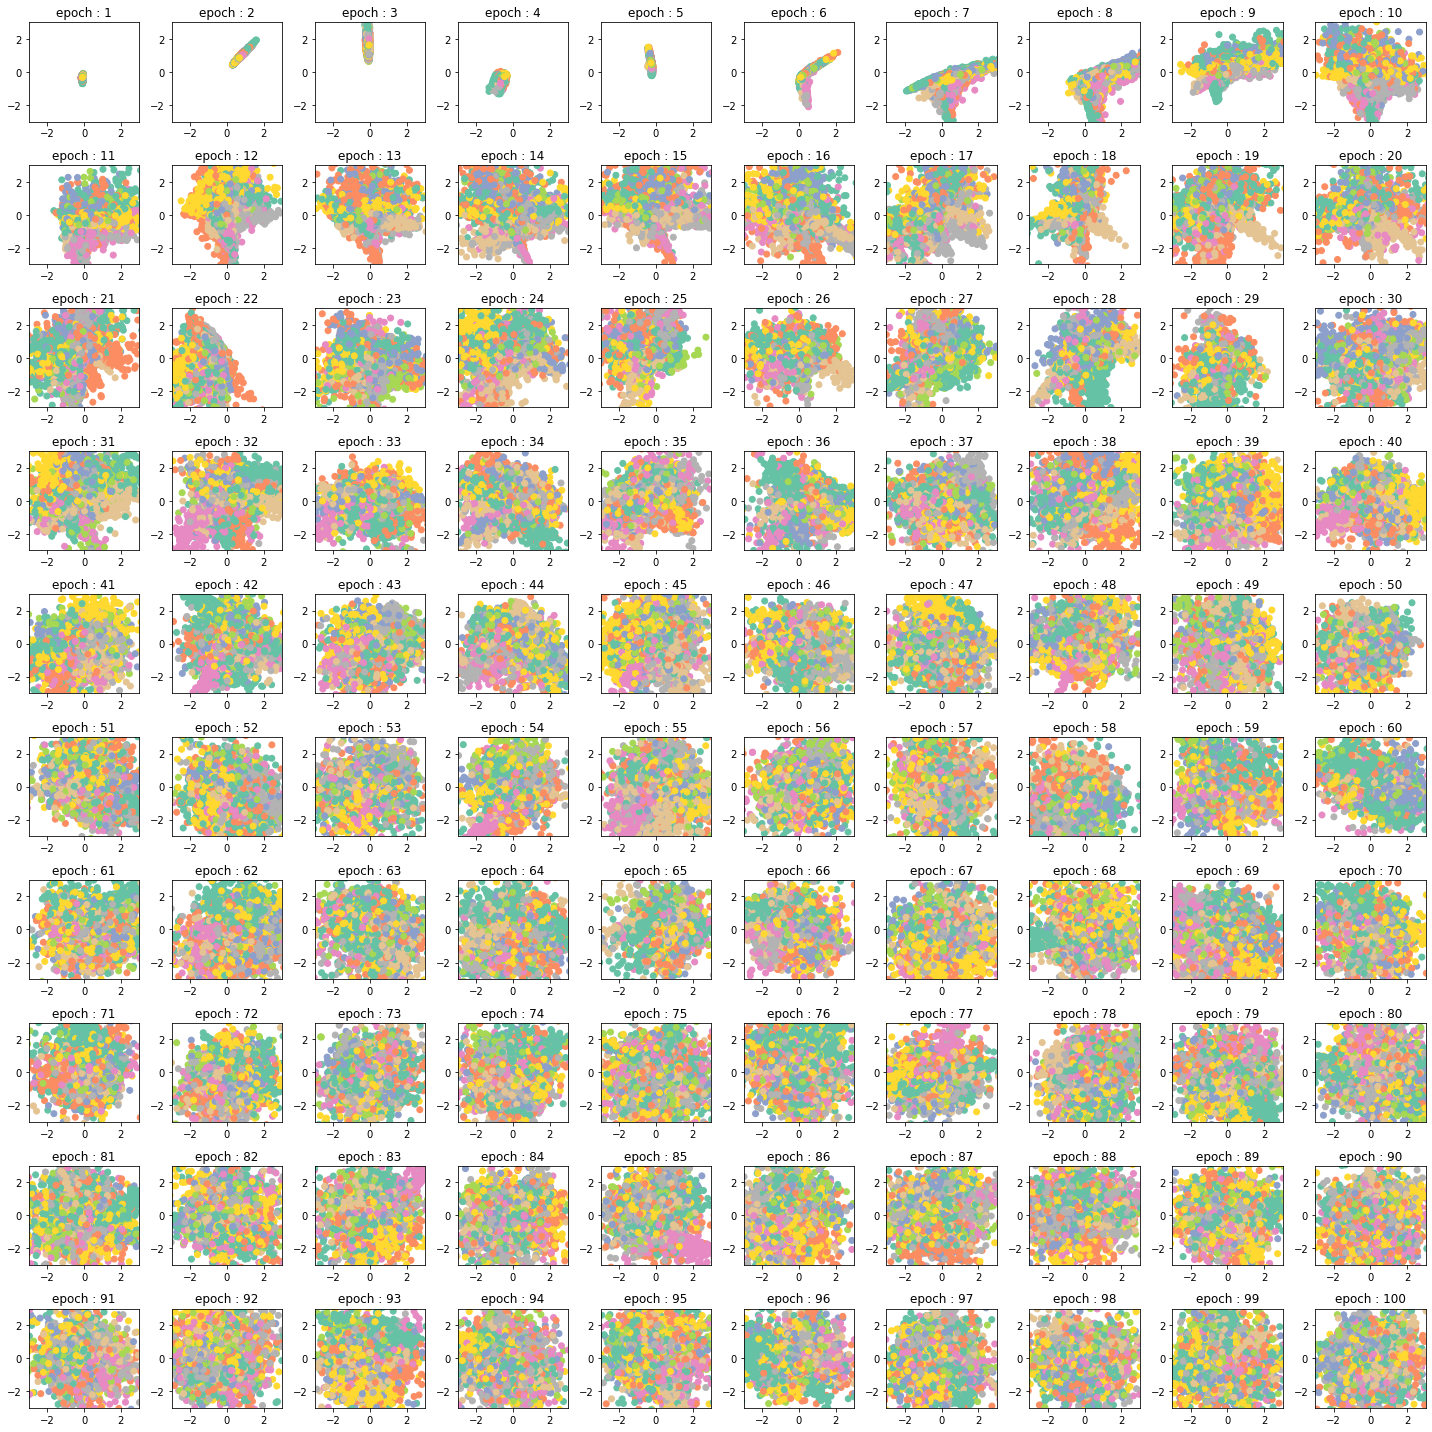

In [5]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_z_history[i][:,0], latent_z_history[i][:,1], c = color, cmap = plt.cm.Set2)
    ax[i//10, i%10].set_title(f'epoch : {i + 1}')
    ax[i//10, i%10].set_xlim(-3,3)
    ax[i//10, i%10].set_ylim(-3,3)
plt.tight_layout()